---
title: Head Coaches 
description: Exploratory data analysis of the head coaches dataset
---

### Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns

In [33]:
sns.set_theme(context = 'paper', style = 'ticks', palette = 'deep', color_codes = True)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300

### Loading data

In [34]:
head_coach = pd.read_csv('data/head_coach.csv', parse_dates=['Appointed', 'EndDate'])
head_coach_dismissed = head_coach[head_coach['EndDate'].notnull()]

long_tenure = head_coach[head_coach['Tenure'] > 3000].shape[0]

Il y a {eval}`long_tenure` entraîneurs avec plus de 3000 jours en poste. Cela concerne Arsene Wenger qui a été responsable d’Arsenal pendant 7046 jours.

### Basic plots

In [35]:
# Useful to add xtick months to dayofyear plot
months = pd.date_range('2022-01-01', '2022-12-31', freq='ME').strftime('%b').tolist()

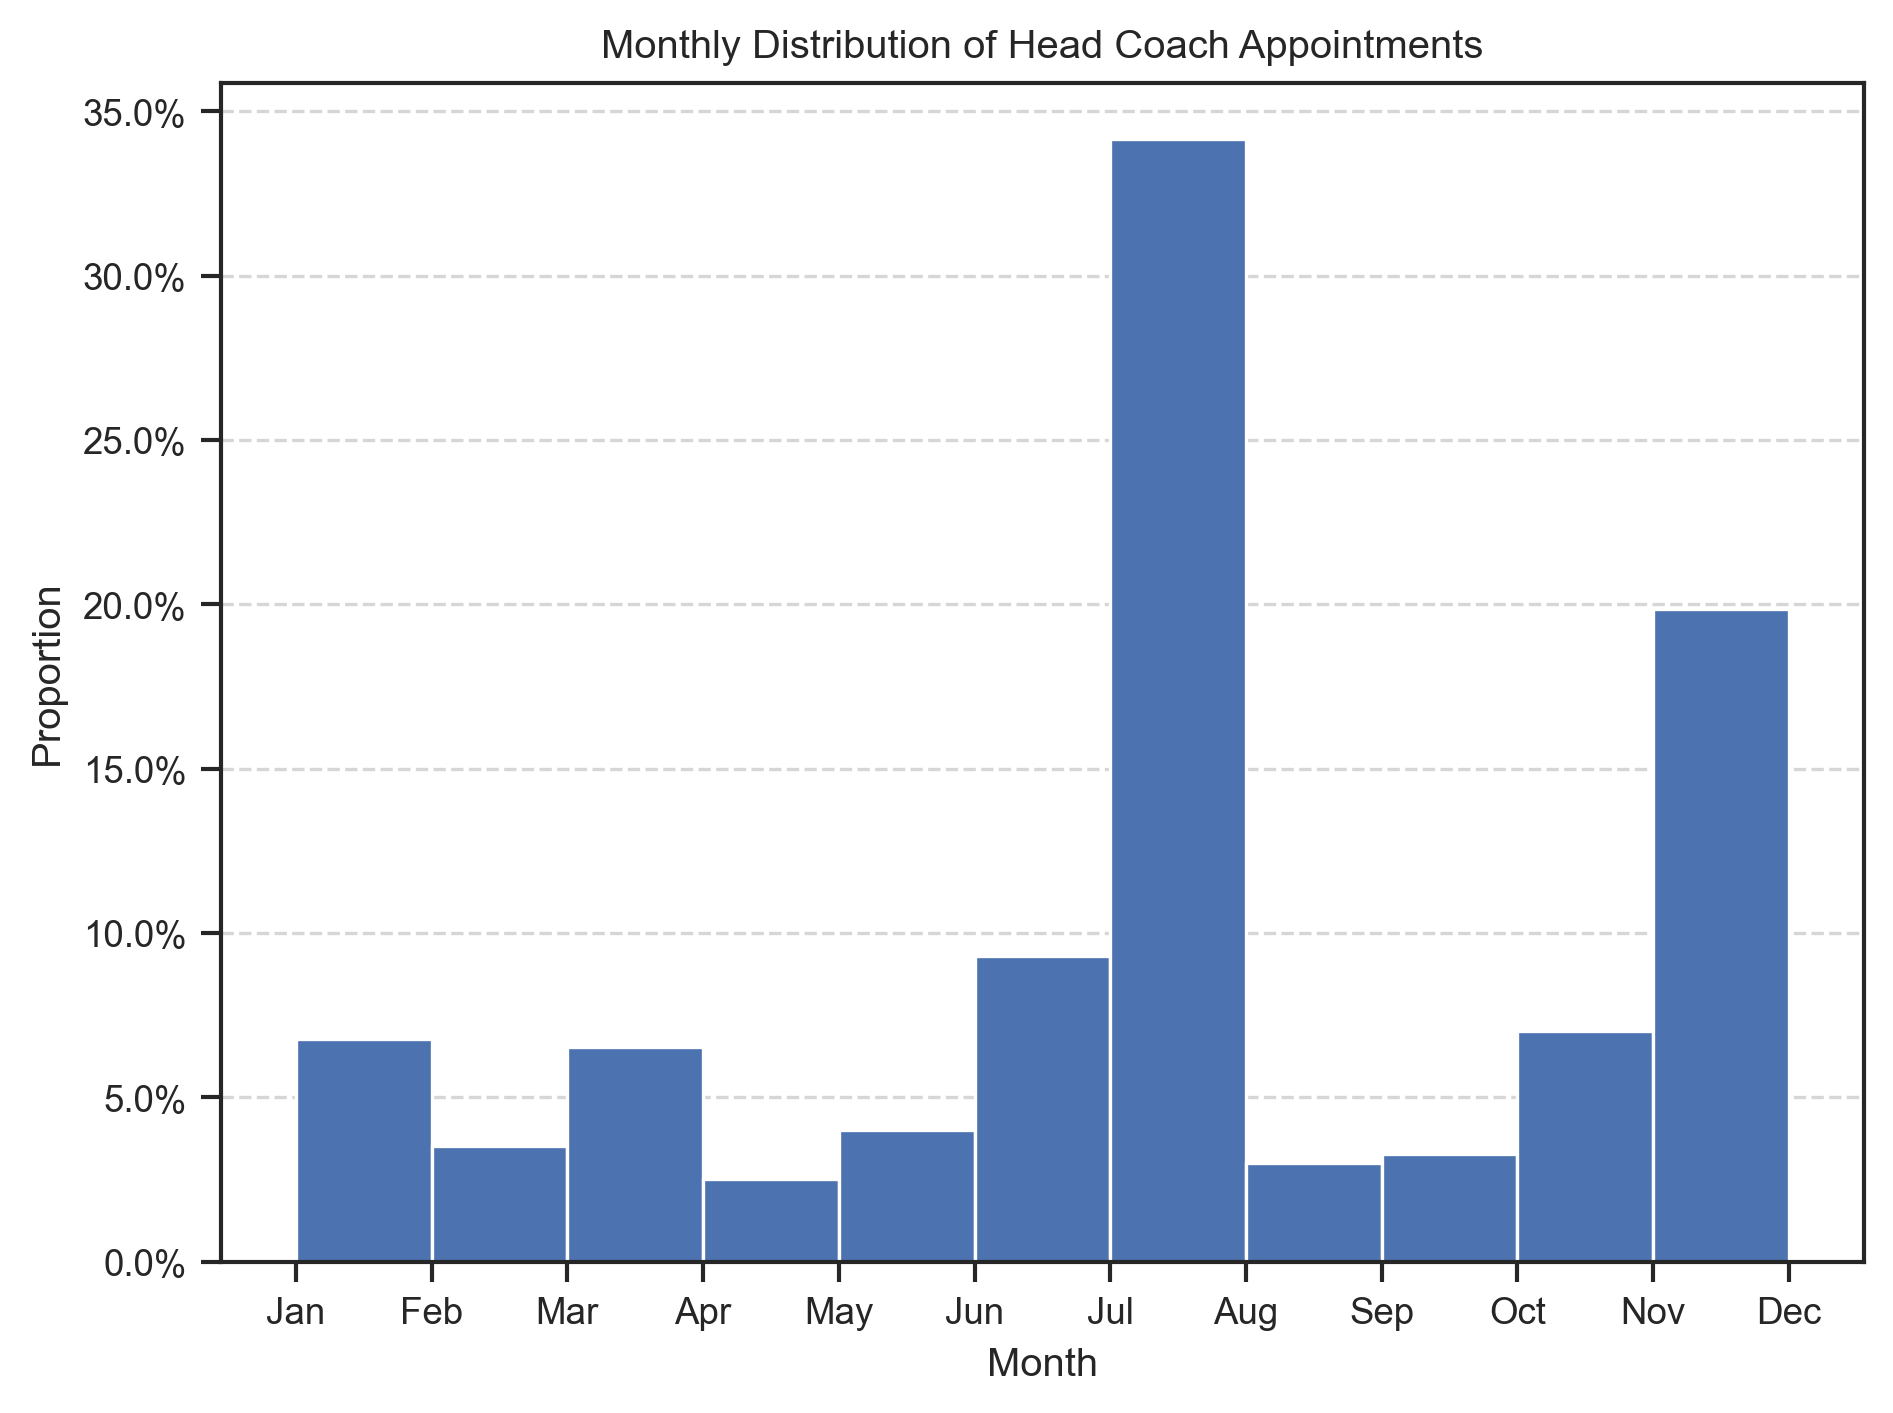

In [36]:
#| label: hc_appointment
plt.figure()
plt.grid(axis='y', linestyle='--', alpha=0.8)
sns.histplot(head_coach['Appointed'].dt.month, bins=11, color = 'b', kde=False, stat='density', alpha = 1)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.xticks(range(1, 13), months)
plt.title('Monthly Distribution of Head Coach Appointments')
plt.xlabel('Month')
plt.ylabel('Proportion');

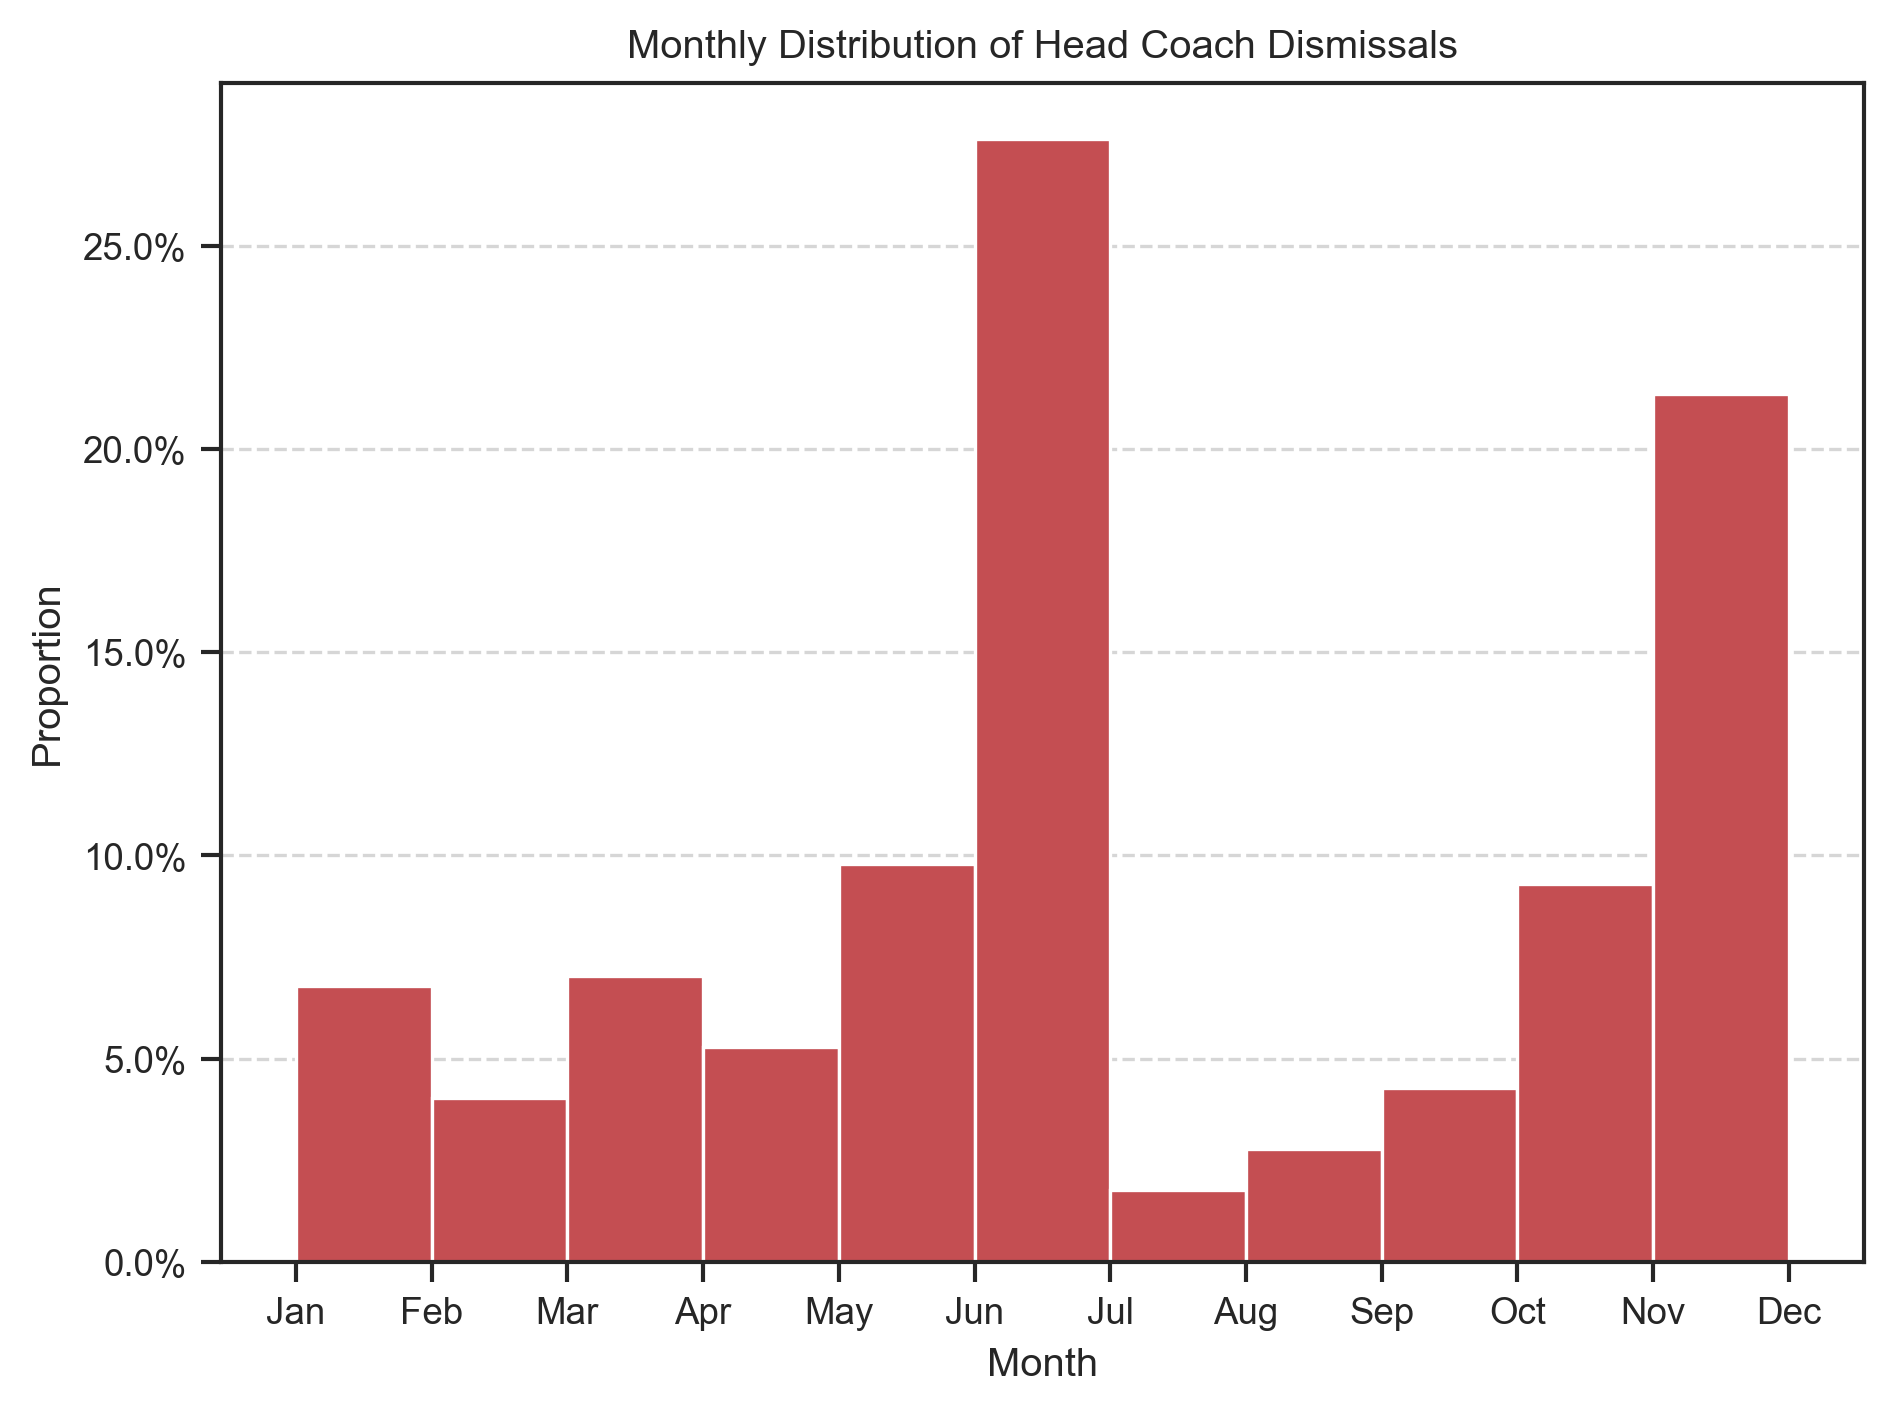

In [37]:
#| label: hc_dismissal
# Plot for Head Coach dismissal distribution
plt.figure()
plt.grid(axis='y', linestyle='--', alpha=0.8)
sns.histplot(head_coach['EndDate'].dt.month, bins=11, color = 'r', kde=False, stat='density', alpha = 1)
plt.xticks(range(1, 13), months)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.title('Monthly Distribution of Head Coach Dismissals')
plt.xlabel('Month')
plt.ylabel('Proportion');

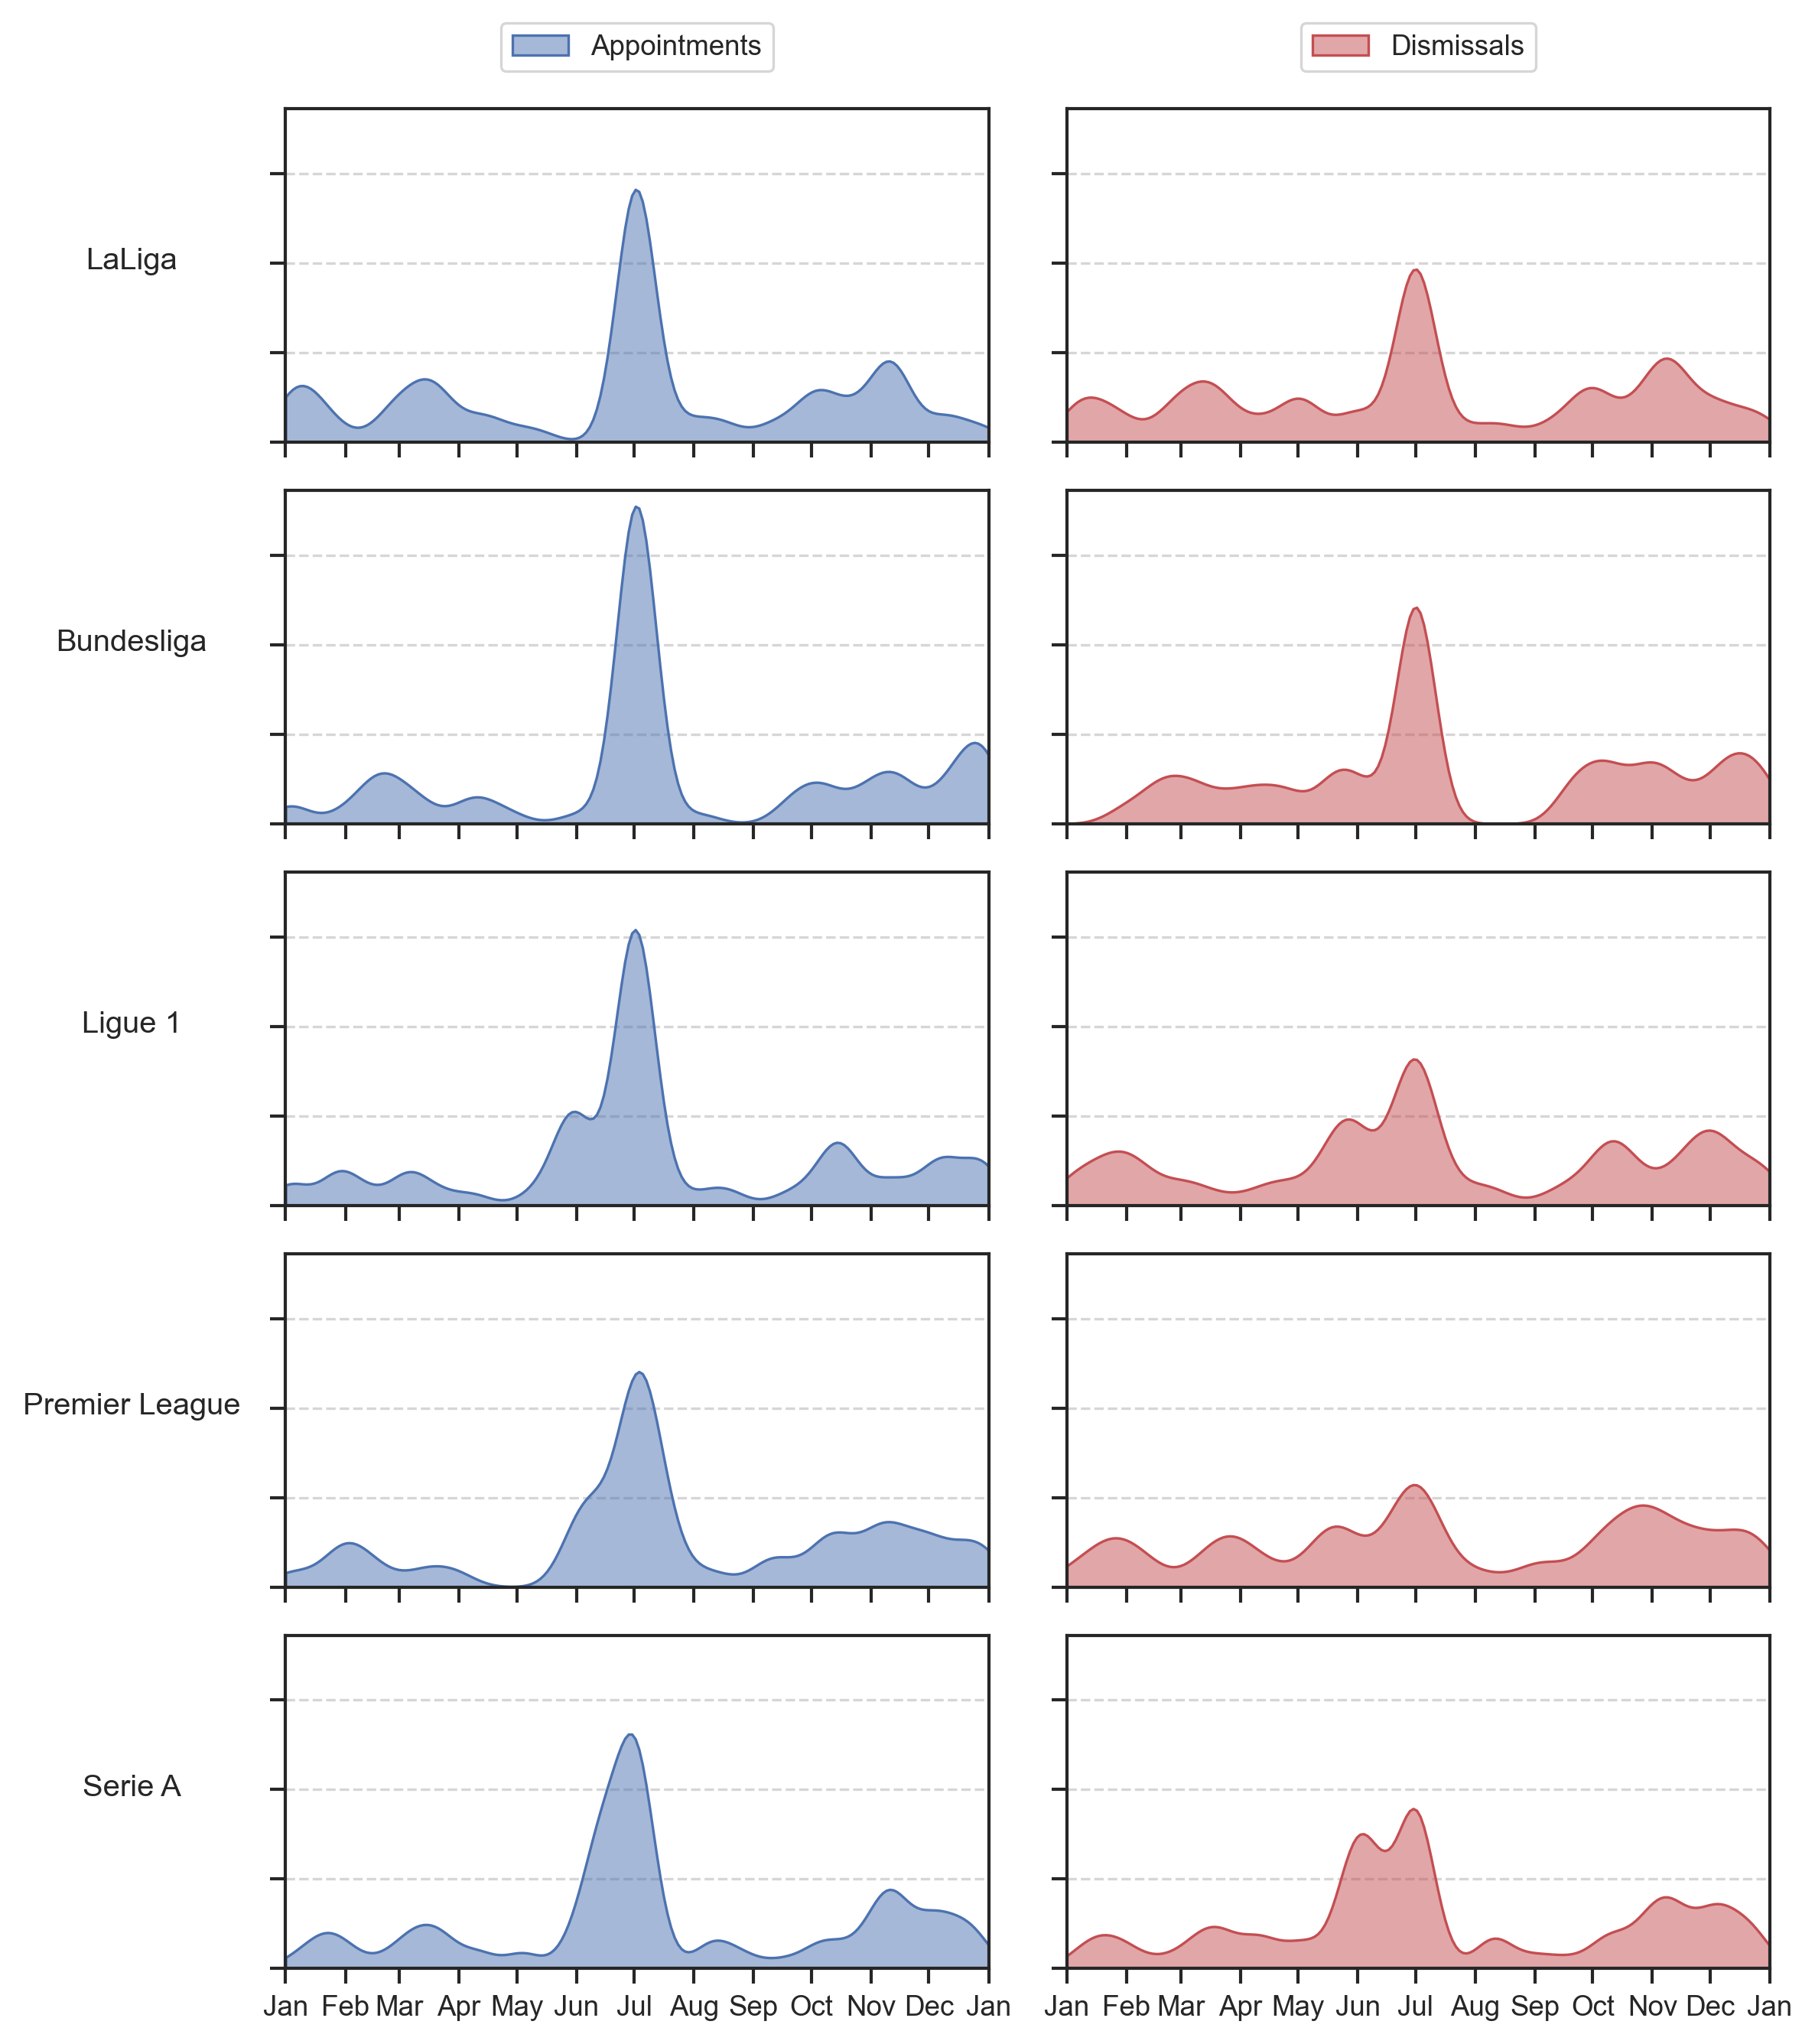

In [98]:
head_coach['AppointedDay'] = head_coach['Appointed'].dt.dayofyear
head_coach_dismissed['DismissedDay'] = head_coach_dismissed['EndDate'].dt.dayofyear

# KDE Plot of head coach appointment/dismissed days of the year versus league
leagues = head_coach['League'].unique()
fig, ax = plt.subplots(len(leagues), 2, figsize=(8, 1.8*len(leagues),), sharex=True, sharey=True)

for i, league in enumerate(leagues):
    sns.kdeplot(data=head_coach[head_coach['League'] == league], x='AppointedDay', ax=ax[i, 0], fill=True, color='b', alpha=0.5, bw_adjust=0.25, clip=(0, 365), label = 'Appointments')
    sns.kdeplot(data=head_coach_dismissed[head_coach_dismissed['League'] == league], x='DismissedDay', ax=ax[i, 1], fill=True, color='r', alpha=0.5, bw_adjust=0.25, clip=(0, 365), label = 'Dismissals')
    ax[i, 0].set_xlim(0, 365)
    ax[i, 1].set_xlim(0, 365)
    # Major formatter for x-axis
    ax[i, 0].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[i, 1].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[i, 0].set_ylabel(league, rotation=0, labelpad=40)
    # Hide y-axis label and ticks
    ax[i, 0].set_yticklabels([])
    ax[i, 1].set_yticklabels([])
    # ax[i, 0].set_yticks([])
    # ax[i, 1].set_yticks([])
    ax[i, 0].grid(axis='y', linestyle='--', alpha=0.8)
    ax[i, 1].grid(axis='y', linestyle='--', alpha=0.8)
    # Remove x-axis label
    ax[i, 0].set_xlabel('')
    ax[i, 1].set_xlabel('')

    if i > 0:
        ax[i, 0].legend().remove()
        ax[i, 1].legend().remove()
    else:
        ax[i, 0].legend()
        ax[i, 1].legend()
        # Place each legend centered on top of their respective axes
        ax[i, 0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
        ax[i, 1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)


<Axes: ylabel='League'>

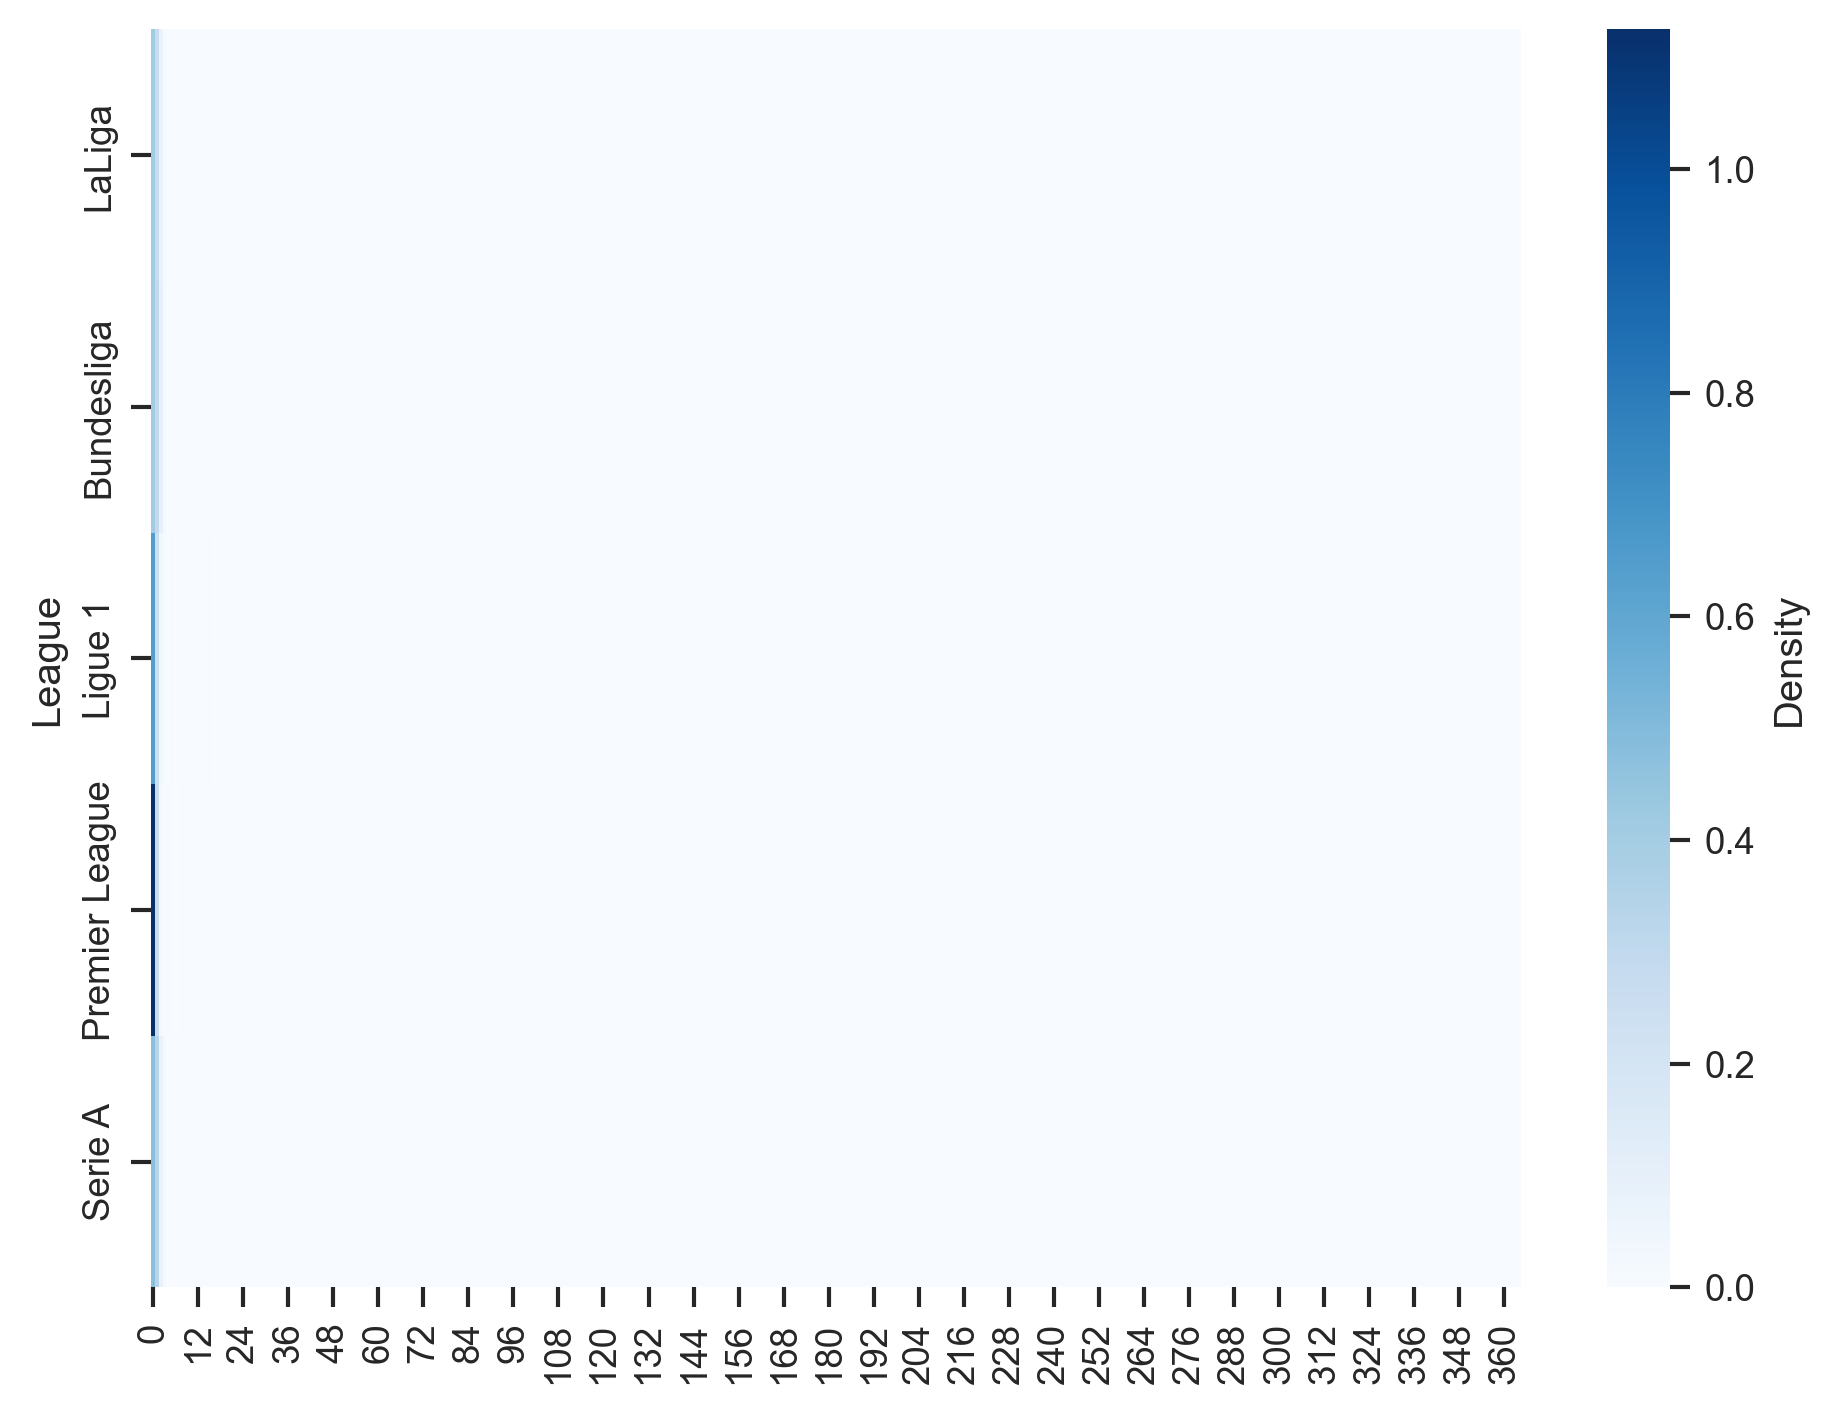

In [121]:
from scipy.stats import gaussian_kde

head_coach['Day'] = head_coach['Appointed'].dt.dayofyear
grouped = head_coach.groupby(['League', 'Day']).size().unstack(fill_value=0)

# Calculer la KDE pour chaque ligue
kde_values = grouped.apply(lambda x: gaussian_kde(x.dropna().values)(np.linspace(0, 365, 365)), axis=1)

# Convertir le résultat en un DataFrame 2D pour le tracé
kde_values = pd.DataFrame(kde_values.to_list(), index=grouped.index)# Tracer le graphique de chaleur
sns.heatmap(kde_values, cmap='Blues', yticklabels=leagues, cbar_kws={'label': 'Density'})
# sns.heatmap(kde_values, cmap='Blues', yticklabels=leagues, cbar_kws={'label': 'Density'})

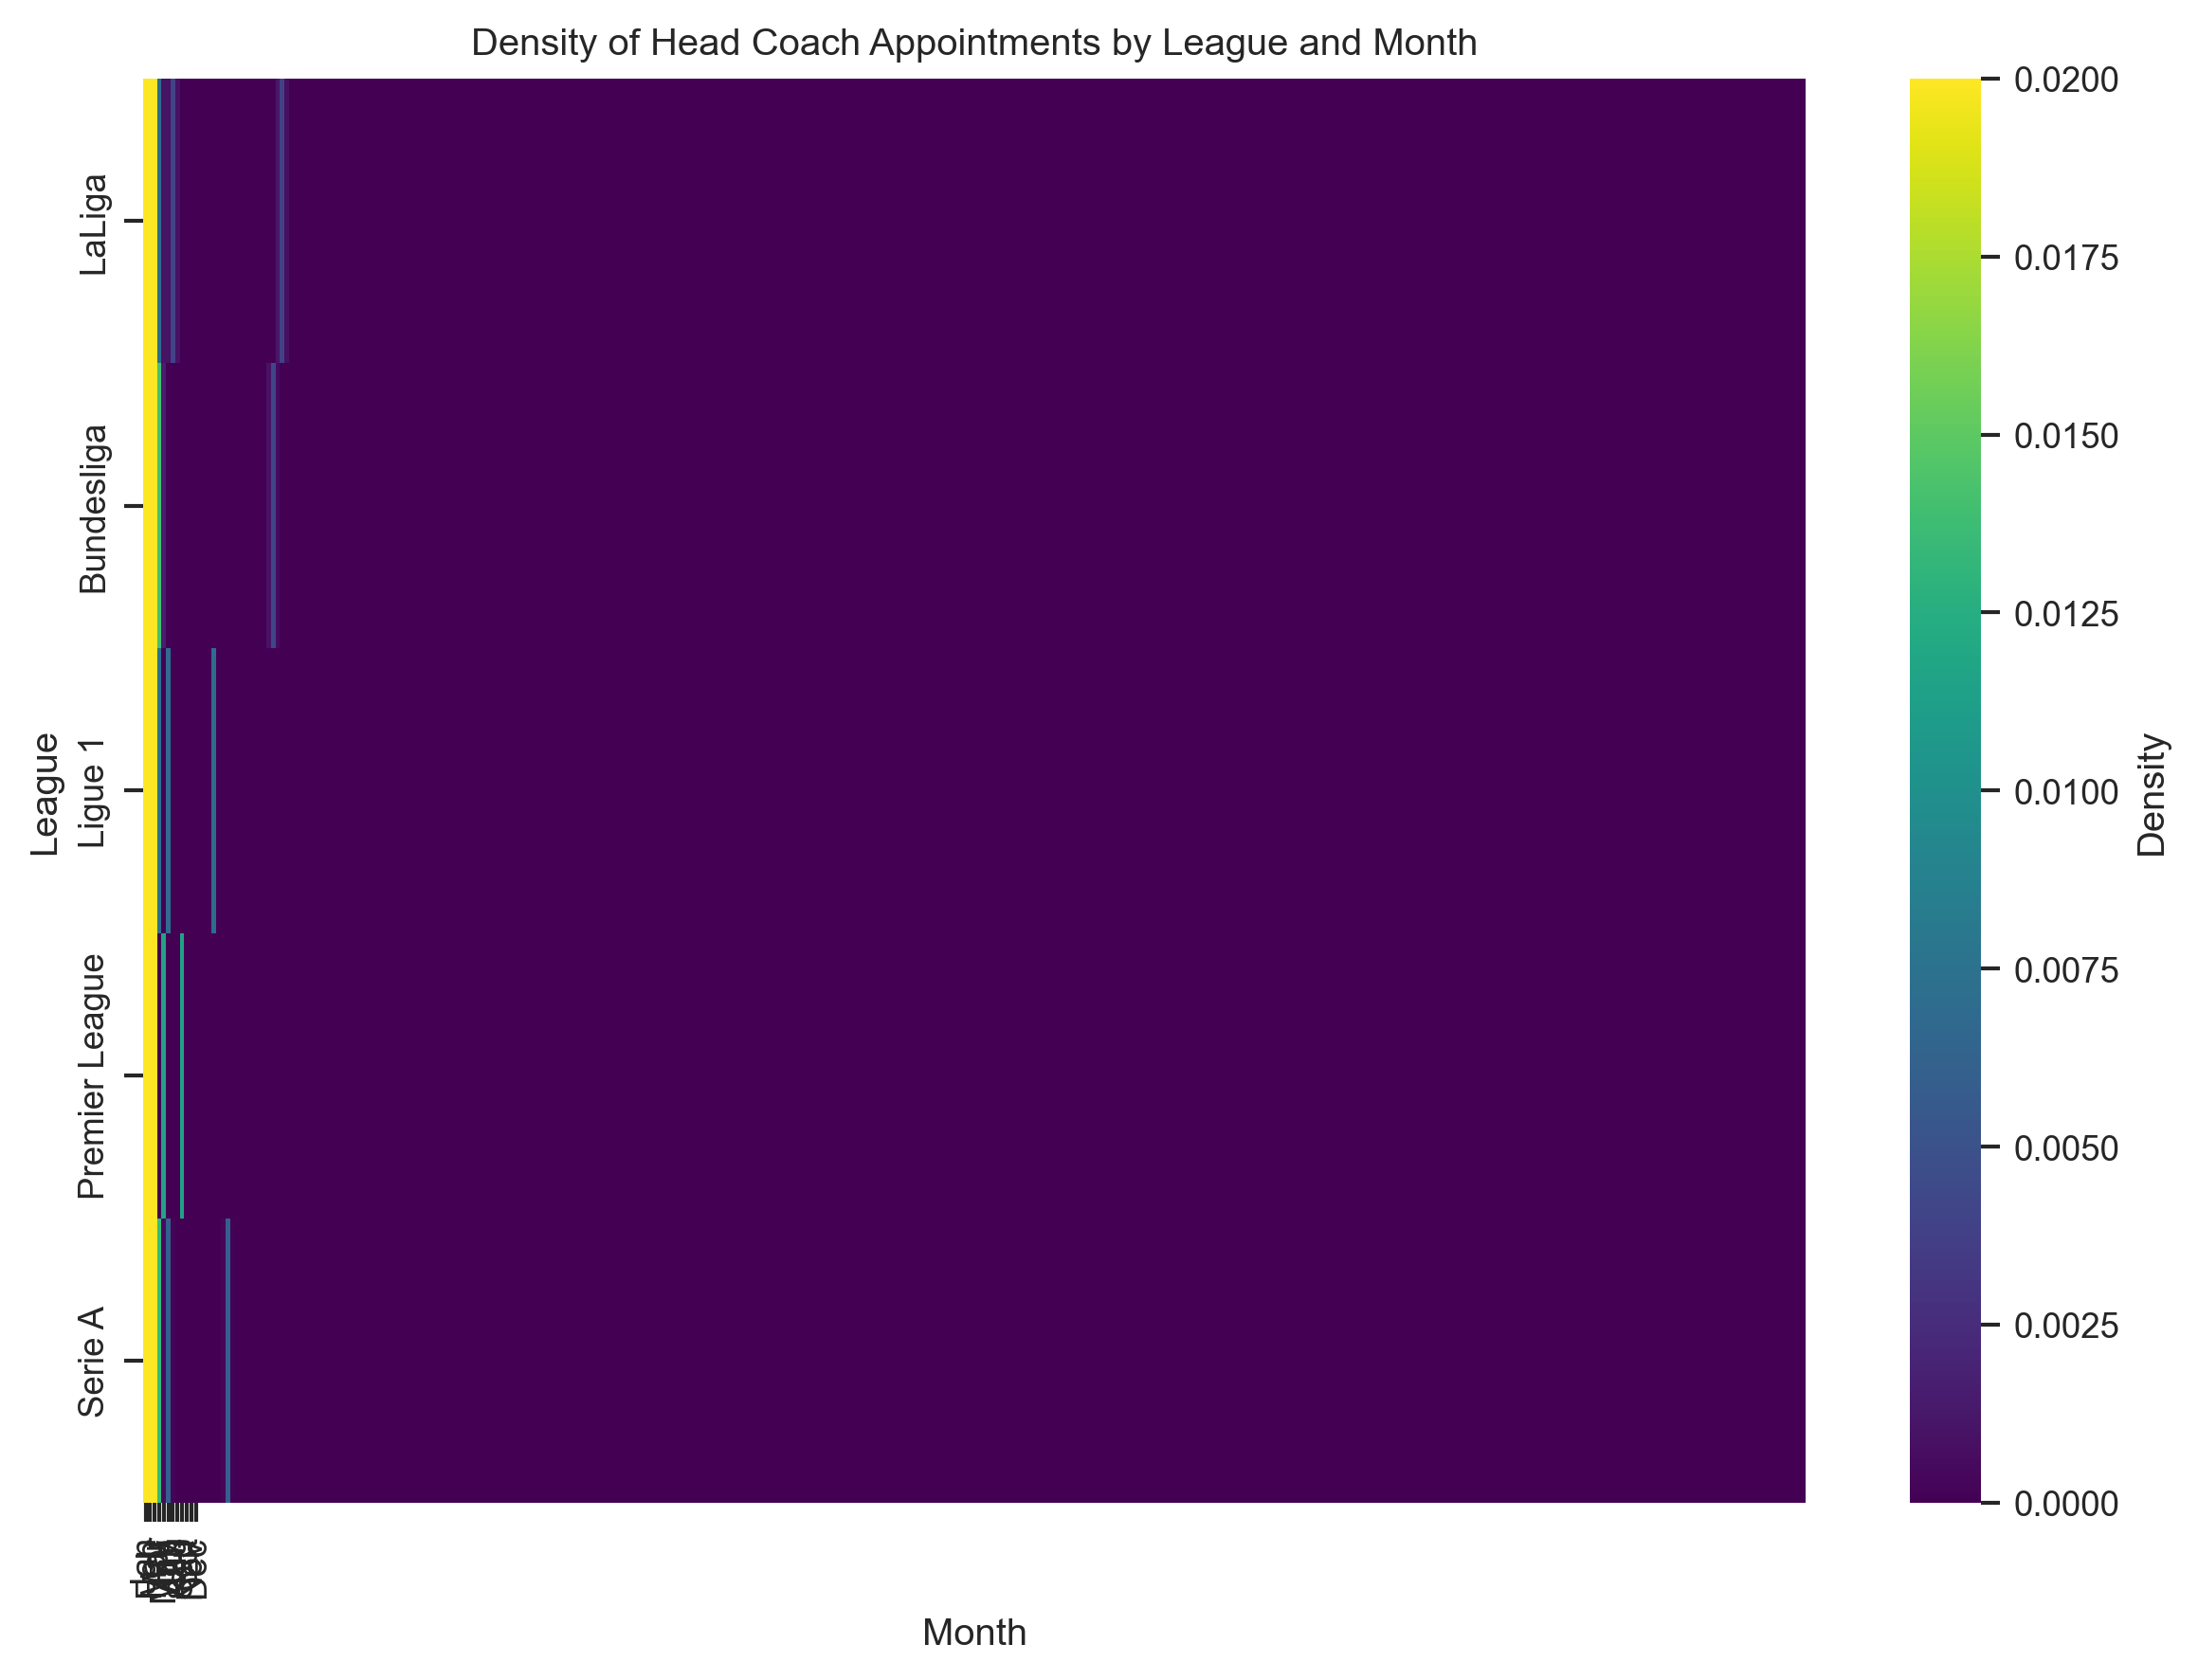

In [111]:

# Plot the KDE values in a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(kde_values, cmap='viridis', xticklabels=months, yticklabels=leagues, cbar_kws={'label': 'Density'})
plt.xlabel('Month')
plt.ylabel('League')
plt.title('Density of Head Coach Appointments by League and Month');

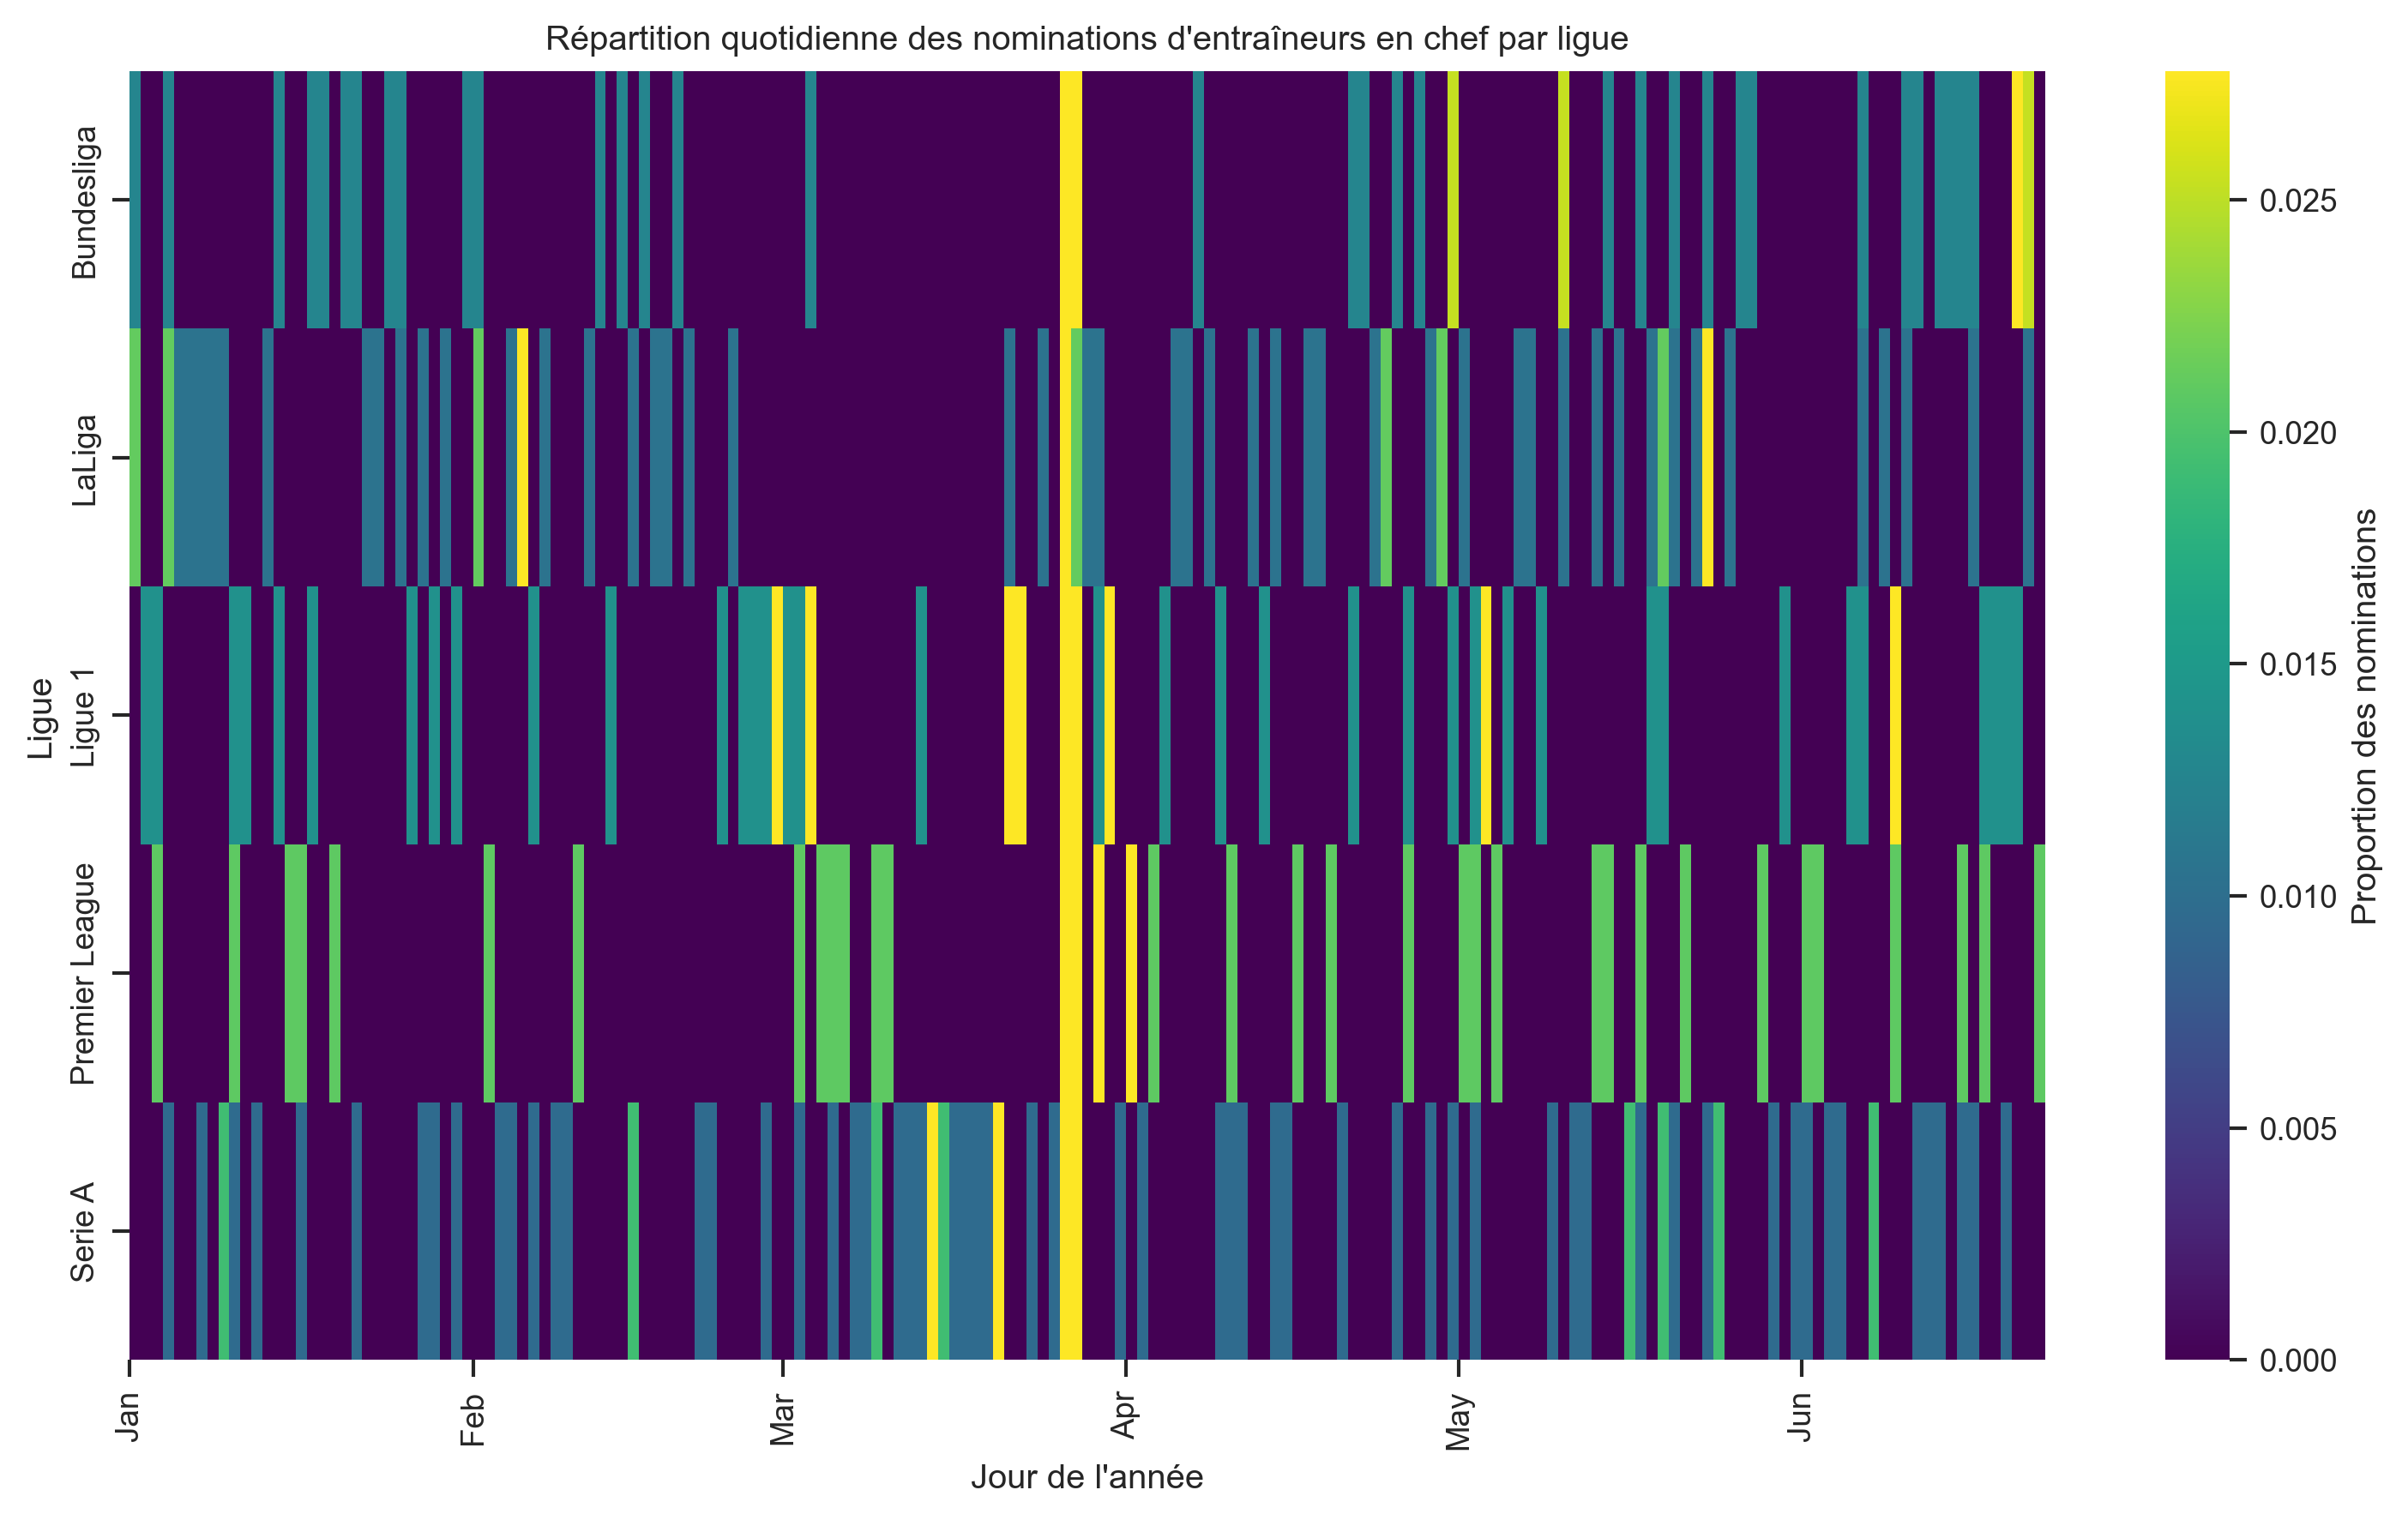

In [99]:
# Créer un DataFrame avec les nominations d'entraîneurs en chef par jour pour chaque ligue
head_coach['Day'] = head_coach['Appointed'].dt.dayofyear
grouped = head_coach.groupby(['League', 'Day']).size().unstack(fill_value=0)

# Normaliser les données pour chaque ligue
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Tracer le graphique de chaleur
plt.figure(figsize=(10, 6))
sns.heatmap(grouped, cmap='viridis', cbar_kws={'label': 'Proportion des nominations'}, robust=True)

# Utiliser les noms des mois comme étiquettes d'axe x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title('Répartition quotidienne des nominations d\'entraîneurs en chef par ligue')
plt.xlabel('Jour de l\'année')
plt.ylabel('Ligue');

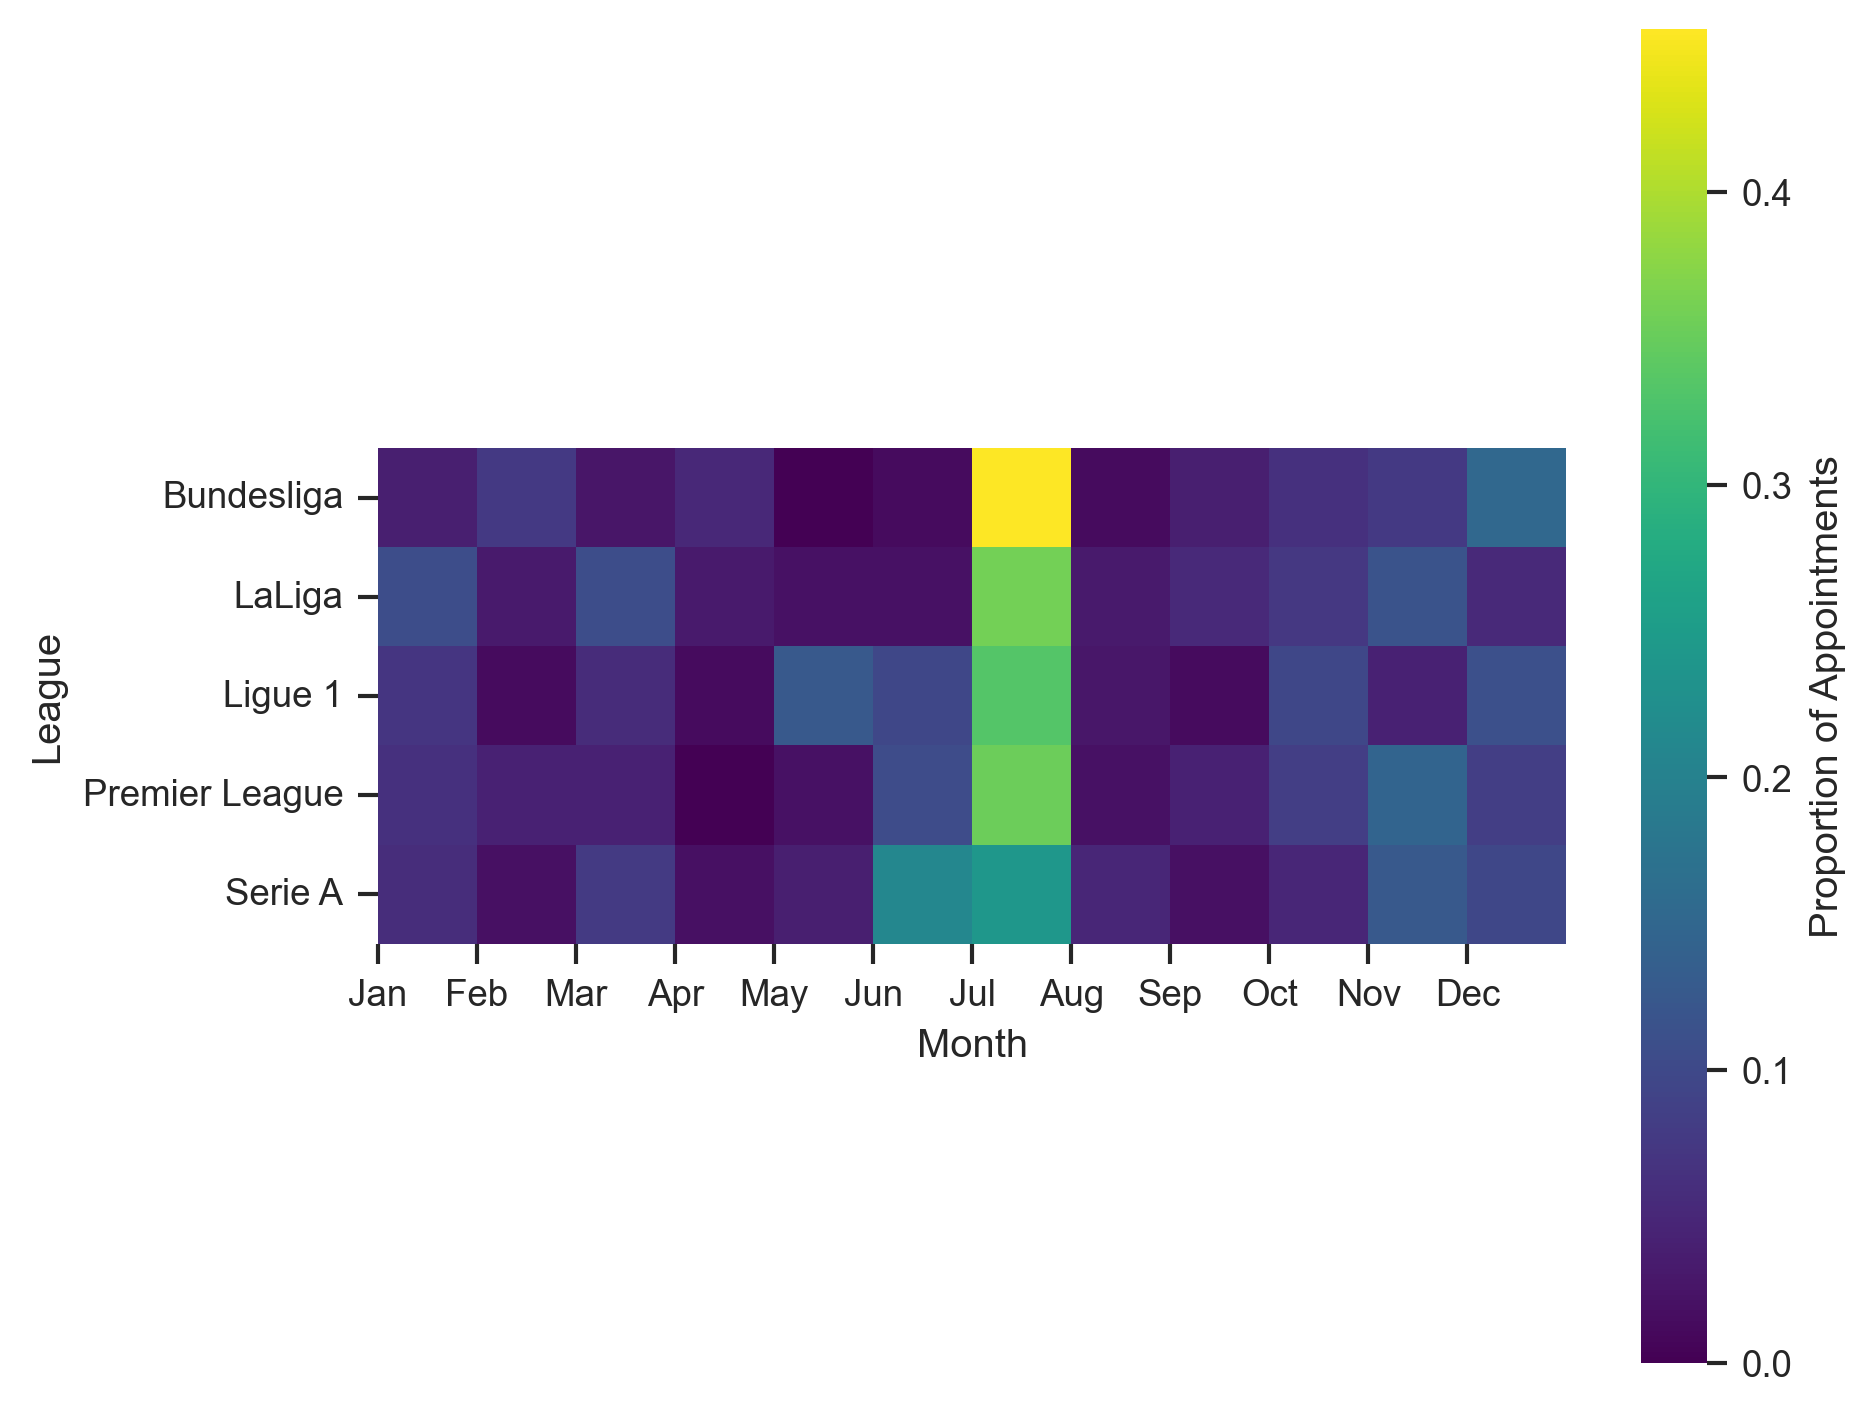

In [ ]:
head_coach['Month'] = head_coach['Appointed'].dt.month
grouped = head_coach.groupby(['League', 'Month']).size().unstack(fill_value=0)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot grouped as heatmap by league
plt.figure()
sns.heatmap(grouped, cmap='viridis', cbar_kws={'label': 'Proportion of Appointments'}, square=True)

# Use month names as xticks
plt.xticks(range(12), months);

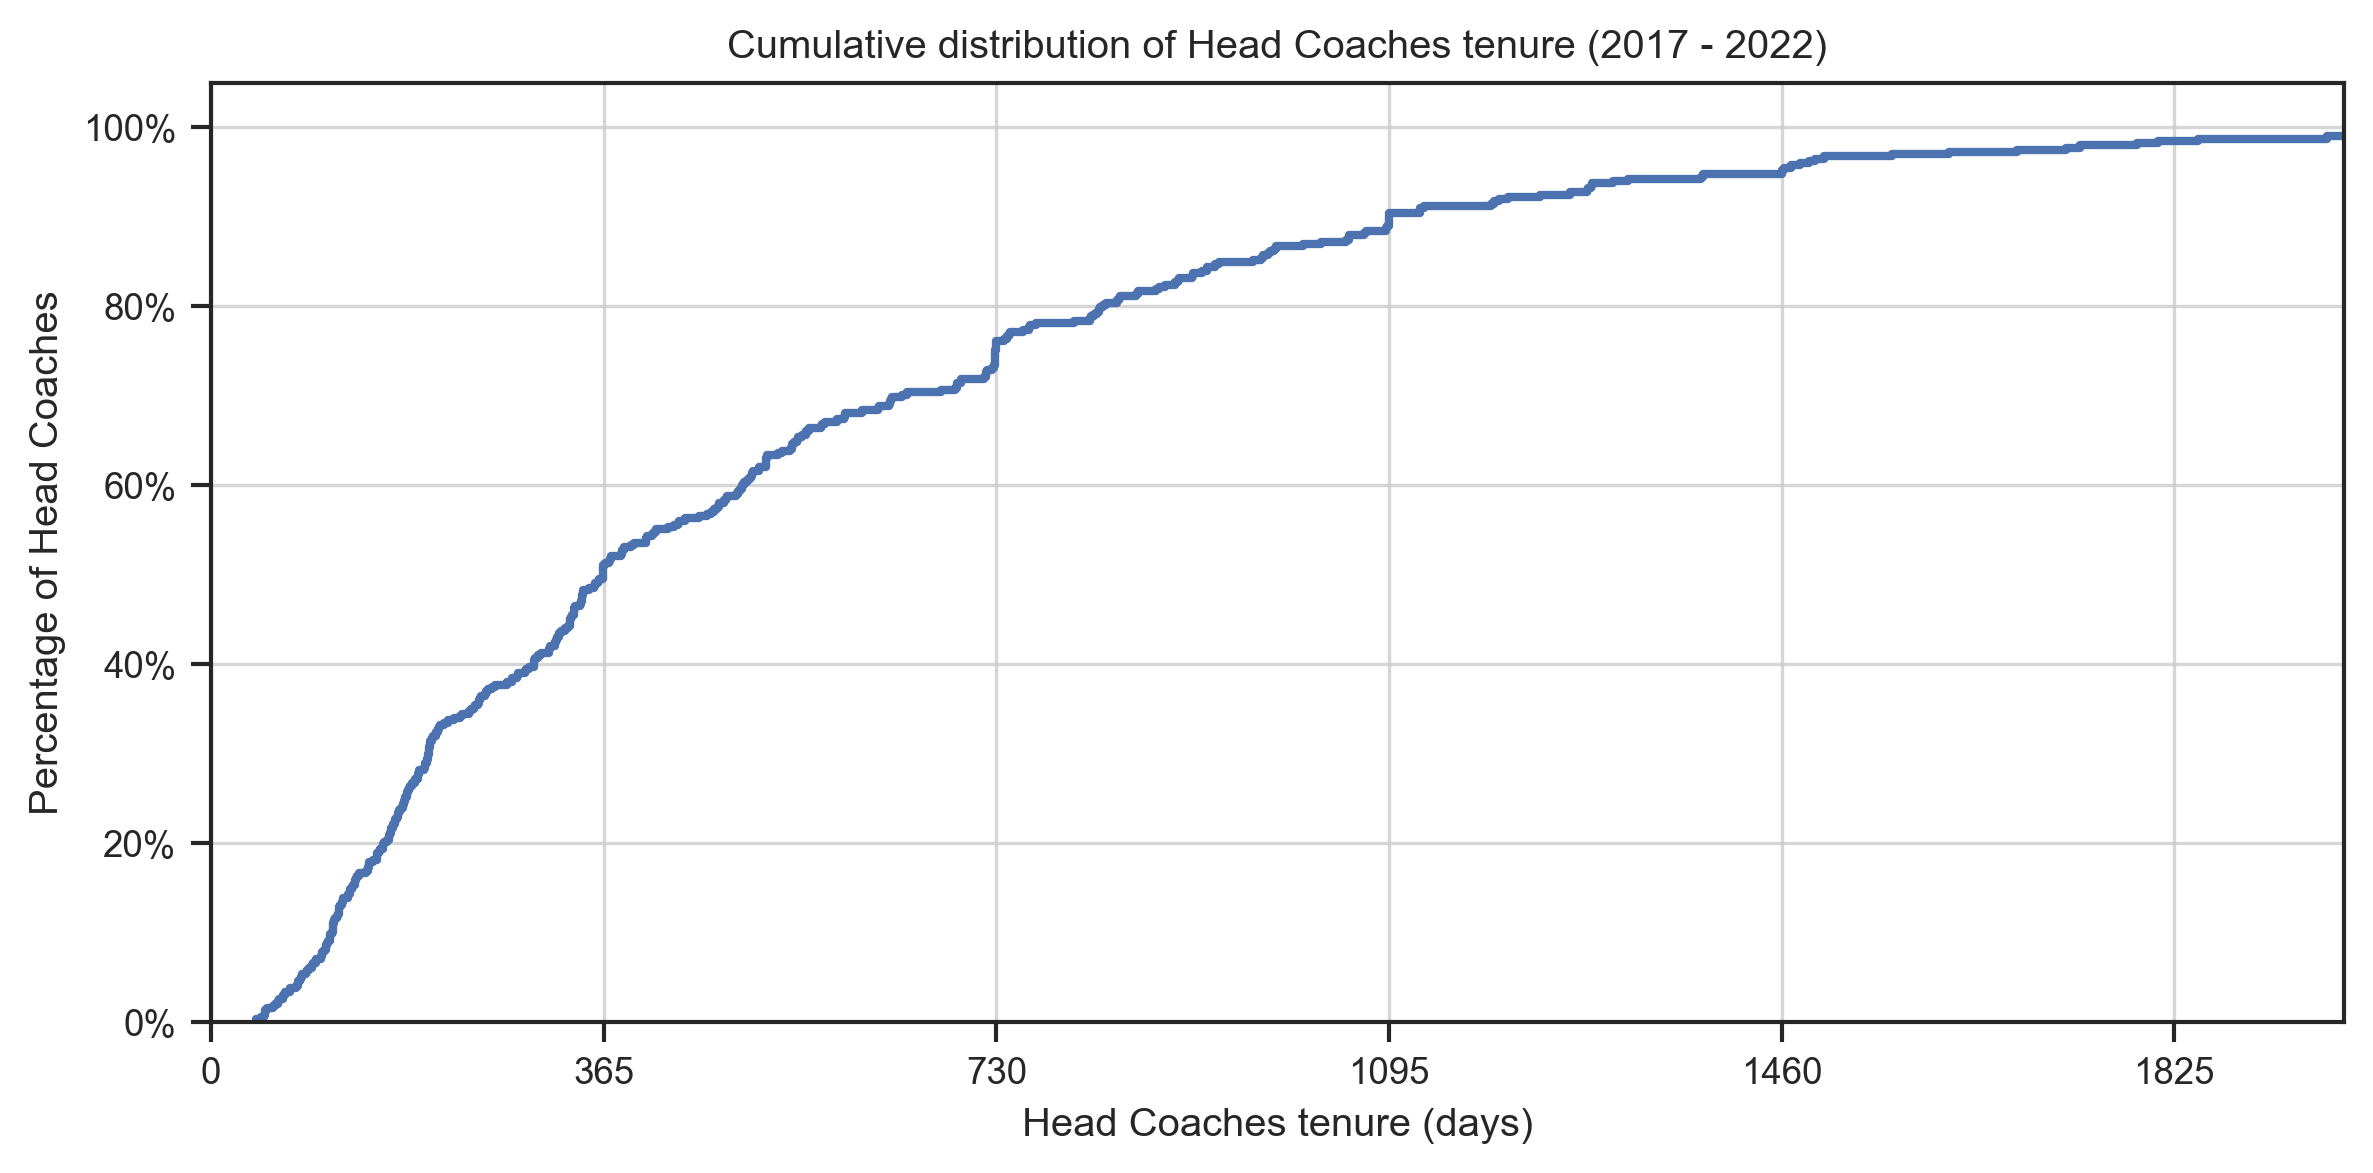

In [ ]:
#| label: hc_tenure
# Plot ECDF of head_coach tenure 
plt.figure(figsize=(8, 4))

sns.ecdfplot(data=head_coach_dismissed, x='Tenure', stat = 'percent', alpha = 1, linewidth = 2)
plt.ylabel('Percentage of Head Coaches')
# Format percentage
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
# Grid
plt.grid(axis='y', linestyle='-', alpha=0.8)
plt.grid(axis='x', linestyle='-', alpha=0.8)
plt.xticks(range(0, max(head_coach_dismissed['Tenure']) + 365, 365))
plt.xlim(0, head_coach_dismissed['Tenure'].quantile(0.99))
plt.title('Cumulative distribution of Head Coaches tenure (2017 - 2022)')
plt.xlabel('Head Coaches tenure (days)');
# plt.savefig('figures/hc_tenure.png')

En moyenne, les entraîneurs sportifs sont restés en poste {eval}`round(head_coach_dismissed['Tenure'].mean())` jours.

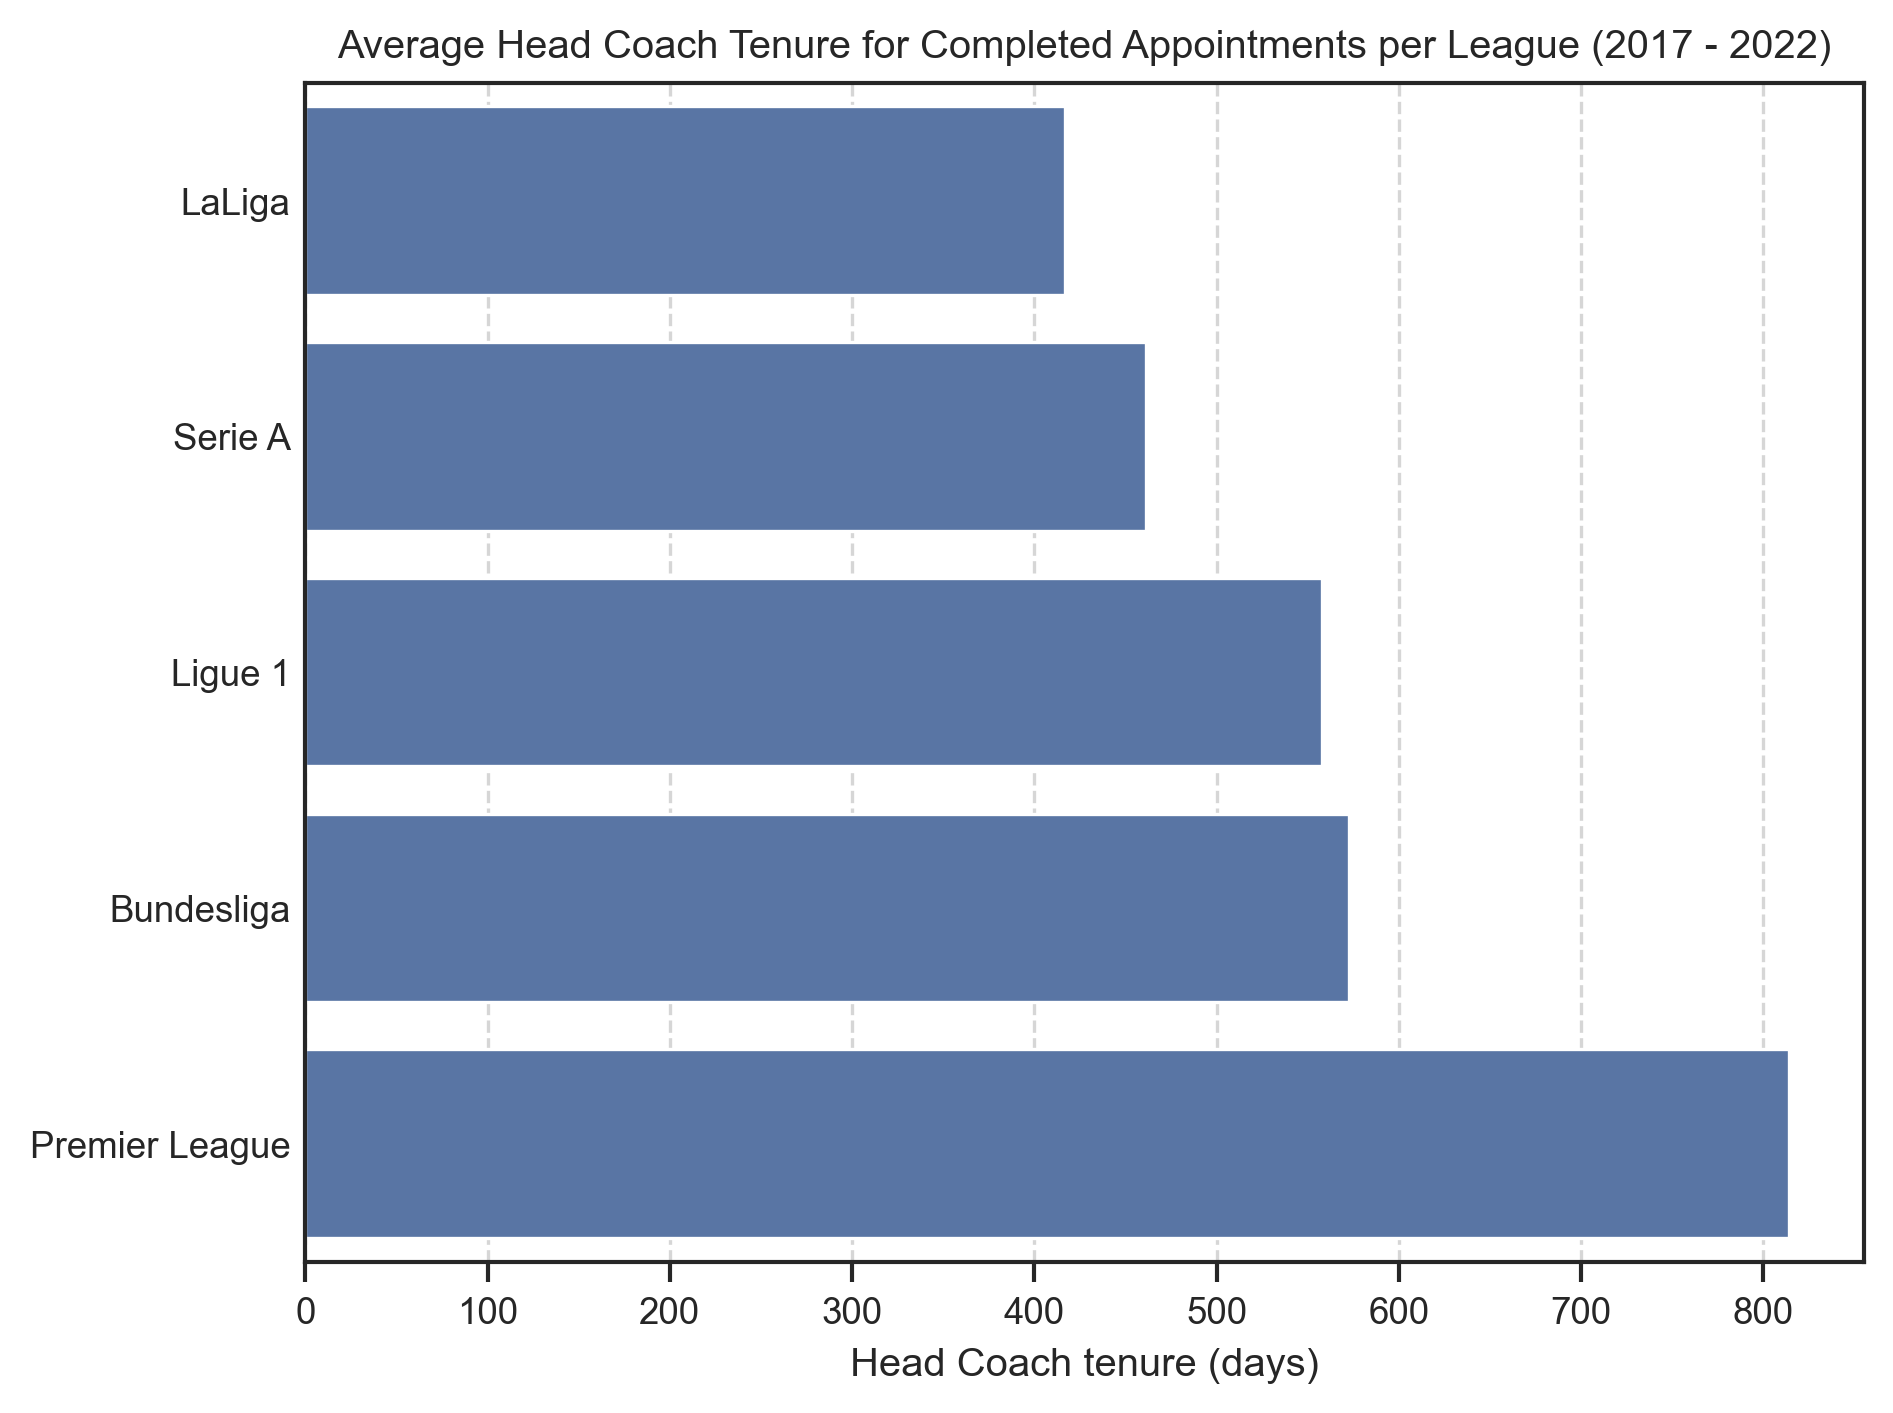

In [ ]:
#| label: hc_tenure_per_league
# Average days in post per league 

# Calculate average days in post per league
avg_days_in_post = head_coach_dismissed.groupby('League')['Tenure'].mean()
avg_days_in_post = avg_days_in_post.sort_values()

# Plot average days in post per league
plt.figure()
sns.barplot(y=avg_days_in_post.index, x=avg_days_in_post.values, orient='h')
plt.title('Average Head Coach Tenure for Completed Appointments per League (2017 - 2022)')
plt.xlabel('Head Coach tenure (days)')
plt.tick_params(axis='y', which='both', length=0)
# Disable ylabel
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.8)

# plt.savefig('figures/hc_tenure_per_league.png')

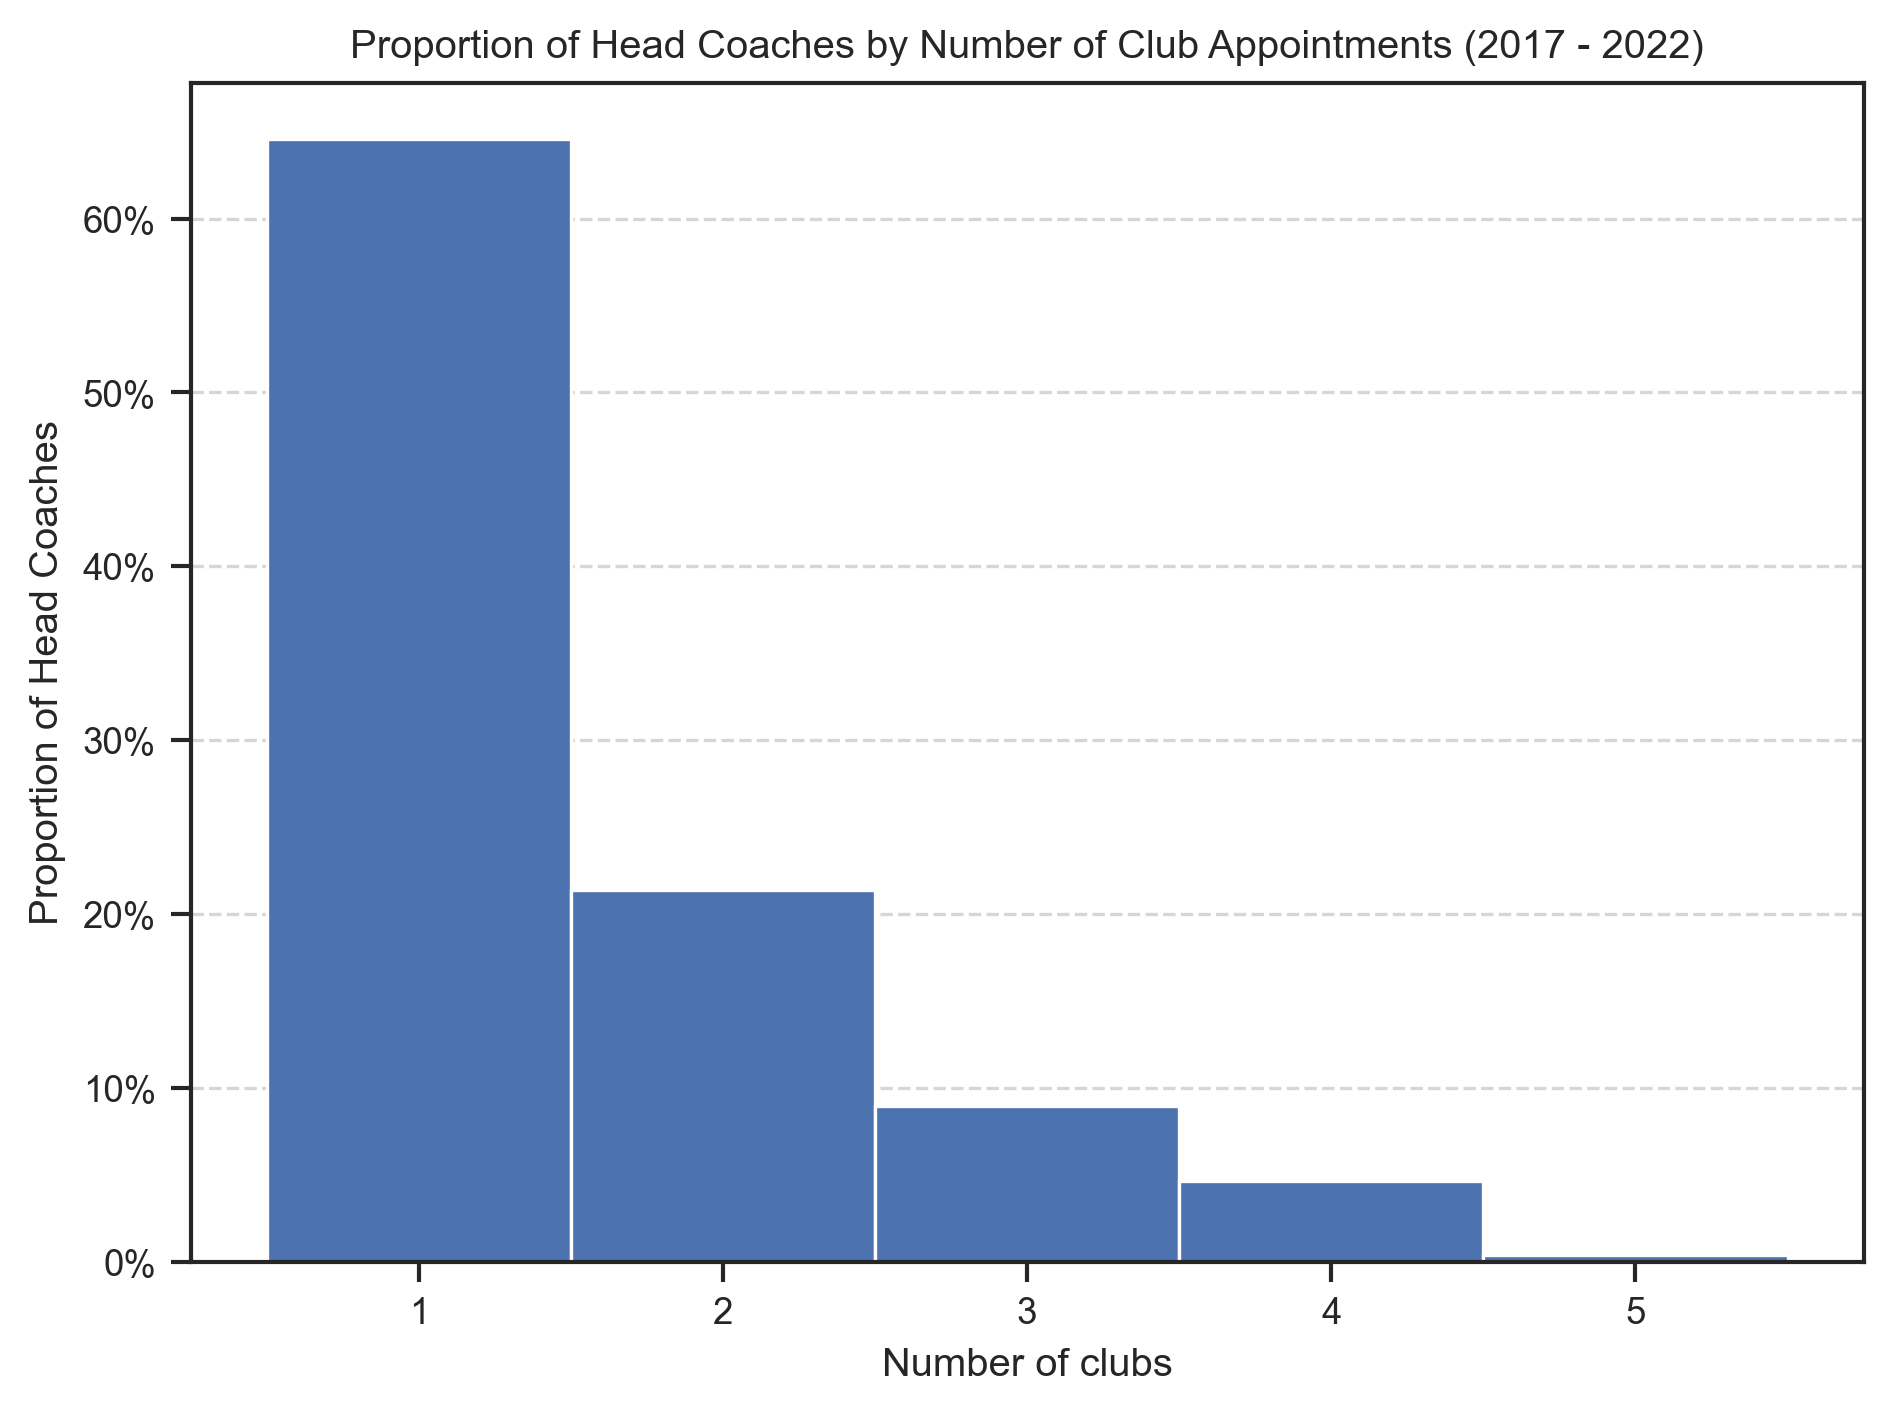

In [ ]:
#| label: club_per_hc
# Number of clubs per Head Coach

# Group by coach_name and count the number of clubs
club_per_coach = head_coach.groupby('HeadCoach').size().reset_index(name='count')

plt.figure()
sns.histplot(x='count', data = club_per_coach, discrete = True, stat="probability", alpha = 1)
plt.xticks(range(1, club_per_coach['count'].max() + 1))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.title('Proportion of Head Coaches by Number of Club Appointments (2017 - 2022)')
plt.xlabel('Number of clubs')
plt.ylabel('Proportion of Head Coaches')
plt.grid(axis='y', linestyle='--', alpha=0.8)
# plt.savefig('figures/number_of_club_per_coach.png')

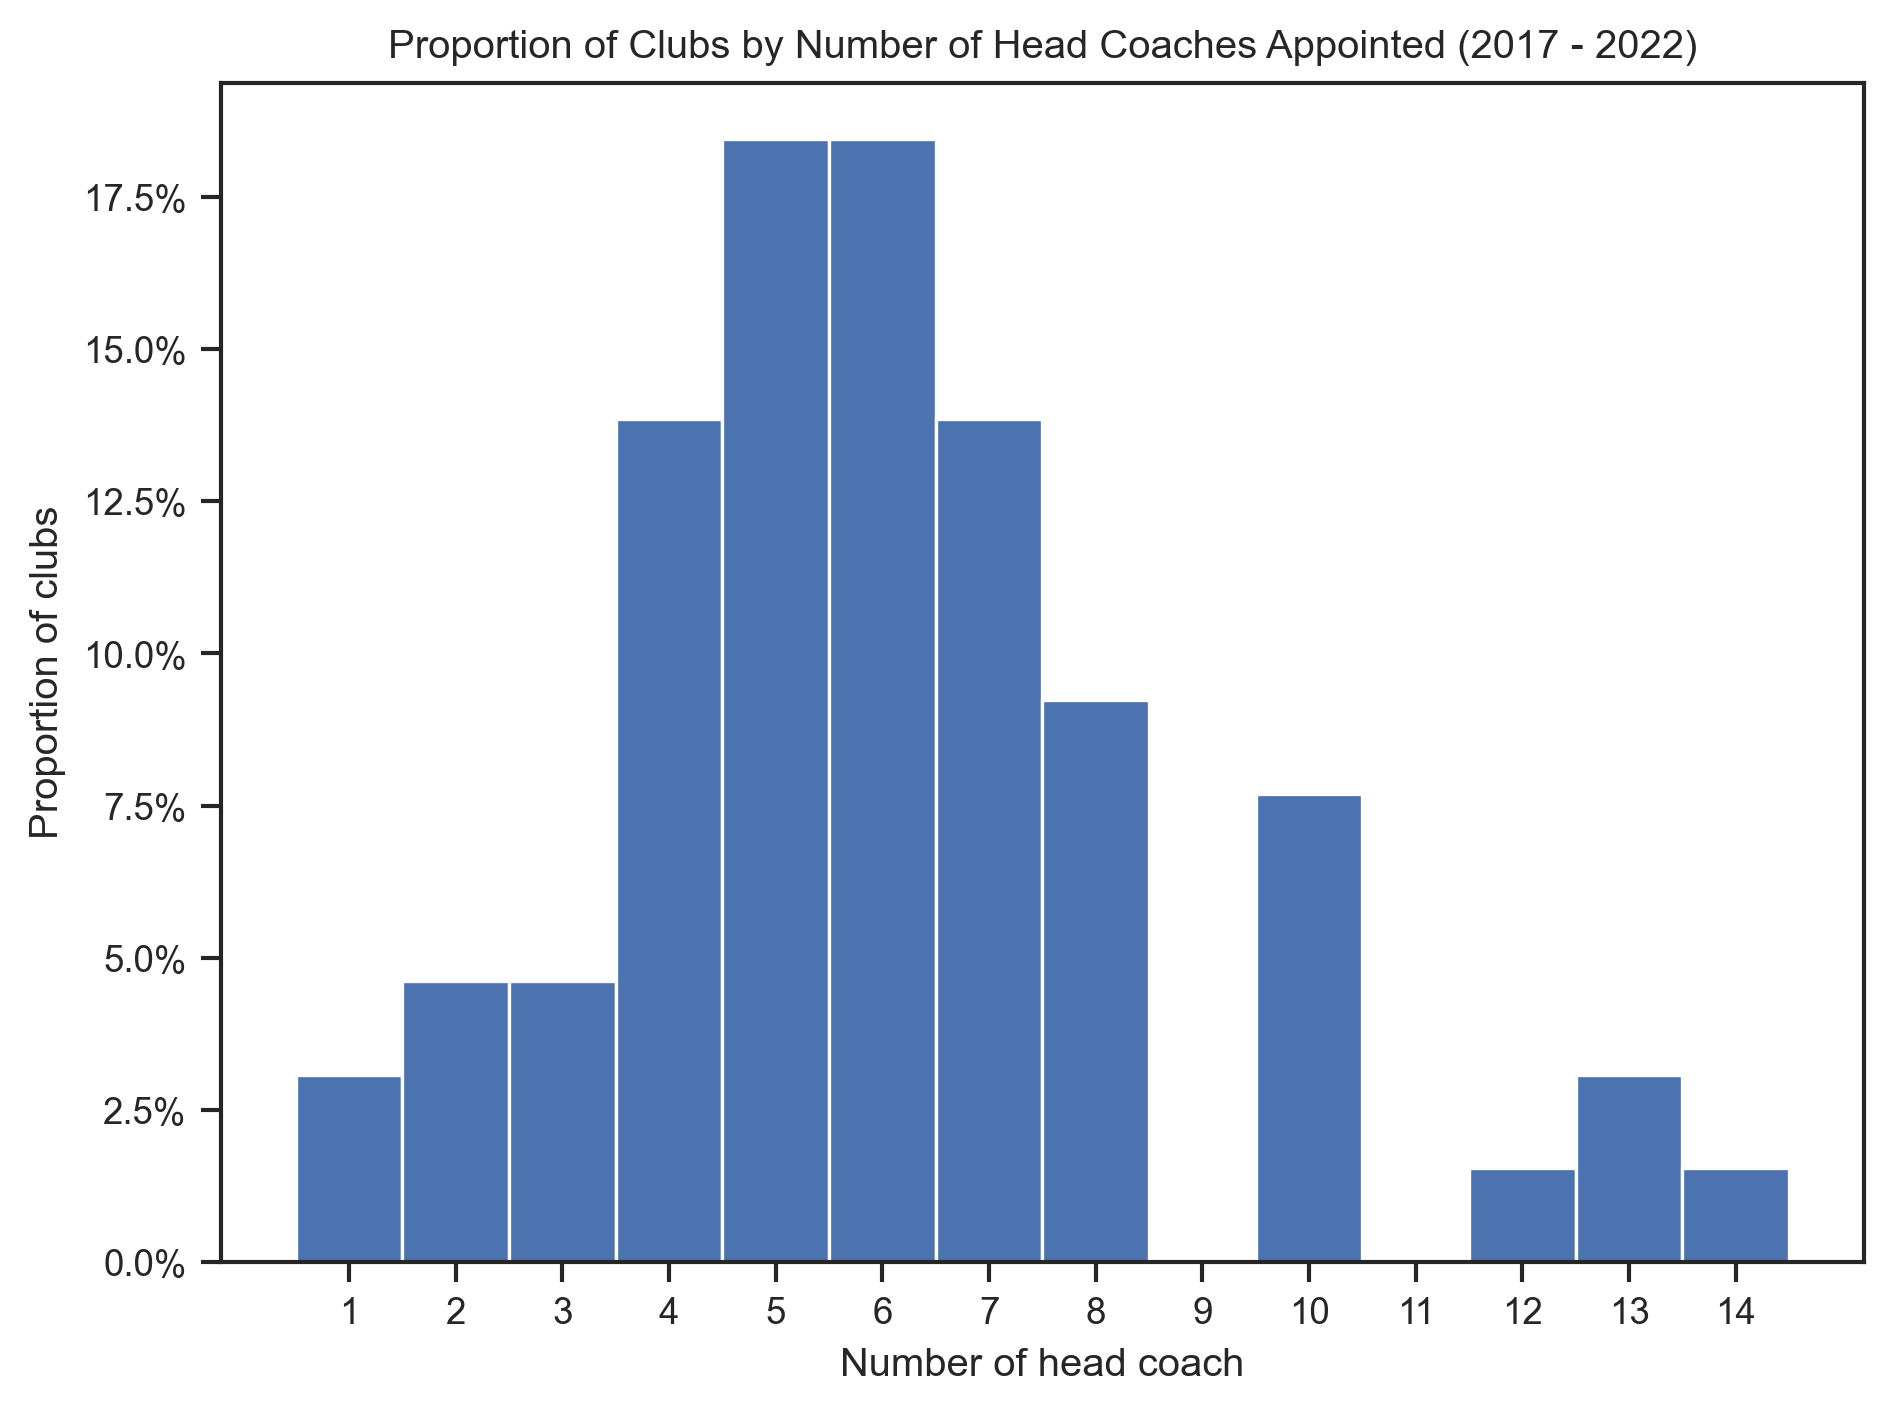

In [ ]:
#| label: hc_per_club
# Number of Head Coachs per club

# Group by team and count the number of head coach
from re import M


coach_per_club = head_coach.groupby('Team').size().reset_index(name='count')

plt.figure()
sns.histplot(x='count', data = coach_per_club, discrete=True, stat="probability", alpha = 1)
plt.xticks(range(1, coach_per_club['count'].max() + 1))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.title(f'Proportion of Clubs by Number of Head Coaches Appointed (2017 - 2022)')
plt.xlabel('Number of head coach')
plt.ylabel('Proportion of clubs');
# plt.savefig('figures/number_of_coach_per_club.png')

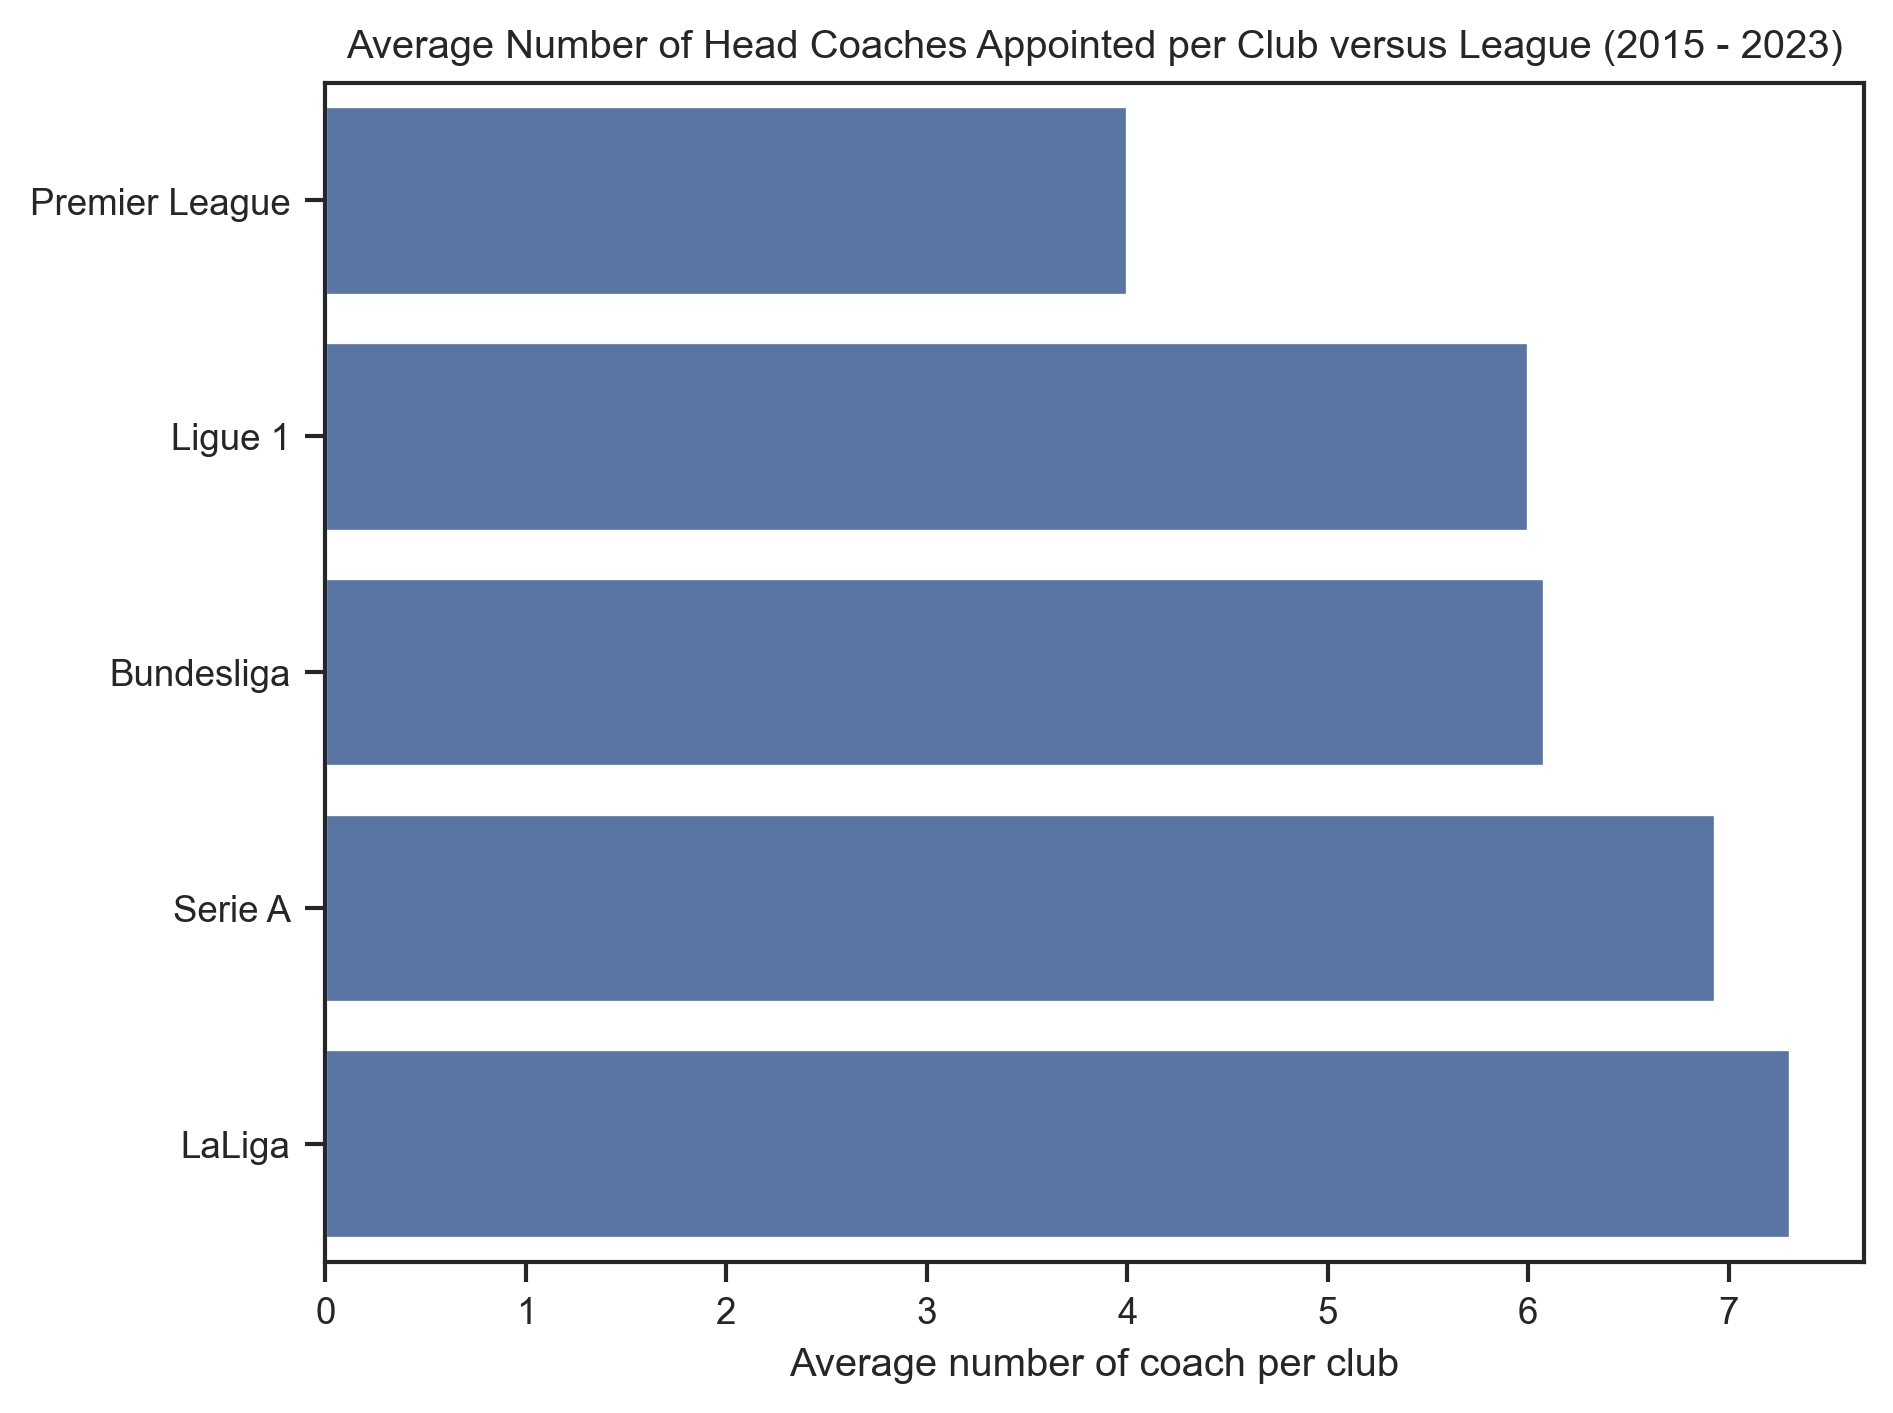

In [ ]:
#| label: hc_per_club_per_league
# Average number of coach per club per league 

# Calculate average number of coach per club per league
coach_per_team = head_coach.groupby(['League', 'Team']).size()
avg_number_of_coach_per_club_per_league = coach_per_team.groupby('League').mean().sort_values()

# Plot average number of coach per club per league
plt.figure()
sns.barplot(x=avg_number_of_coach_per_club_per_league.values, y=avg_number_of_coach_per_club_per_league.index, orient='h')
plt.title('Average Number of Head Coaches Appointed per Club versus League (2015 - 2023)')
plt.ylabel('')
plt.xlabel('Average number of coach per club');
# plt.savefig('figures/hc_per_club_per_league.png')